# Supervised Learning for HR Separations
## August 24, 2015
<hr>

### 1. Go back to the 'raw' data so I can do the transformation in a pipe-oriented way from the start
* start with histret, histcurr, empl and bene
#### define the source repo
* '/home/kesj/lib/repo/'

### 2. Define the correct working directories
* '/data/discovery/hrsepara/core/' for HDFS
* '/data/discovery/hrsepara/staging/eda' and '/home/kesj/working/hrsepara/eda/' for HDFS and LFS on phd


In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'
repodir = '/home/kesj/lib/repo/'

In [2]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')


In [3]:
os.chdir(repodir)
import bear.bear as br

In [4]:
os.chdir(stgdir1local)

## Get the file listing

In [5]:
fnames = !hdfs dfs -ls {coredir}
infilenames = [f.split()[-1] for f in fnames[1:]]
print " there are {0} files in this directory".format(len(infilenames))
infilenames

 there are 16 files in this directory


['/data/discovery/hrsepara/core/EAS',
 '/data/discovery/hrsepara/core/EMPL',
 '/data/discovery/hrsepara/core/HISTCURR',
 '/data/discovery/hrsepara/core/HISTRET',
 '/data/discovery/hrsepara/core/HISTRETold',
 '/data/discovery/hrsepara/core/SBR',
 '/data/discovery/hrsepara/core/SR_BENEFIT.txt',
 '/data/discovery/hrsepara/core/SR_CKE.txt',
 '/data/discovery/hrsepara/core/SR_COMP.txt',
 '/data/discovery/hrsepara/core/SR_CPR.txt',
 '/data/discovery/hrsepara/core/SR_EAS.txt',
 '/data/discovery/hrsepara/core/SR_EDU.txt',
 '/data/discovery/hrsepara/core/SR_INS.txt',
 '/data/discovery/hrsepara/core/SR_LANG.txt',
 '/data/discovery/hrsepara/core/SR_LIC.txt',
 '/data/discovery/hrsepara/core/SR_RELO.txt']

In [6]:
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,sep = ';',dtype_dict = None):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    if dtype_dict != None:
        df = pd.read_csv(inname,sep=sep,dtype =dtype_dict)
    else:
        df = pd.read_csv(inname,sep=sep)
    # clean up local filespace
    !rm {inname}
    return df

## Load the base empl table

In [7]:
empl_df = pandas_read_hdfs(infilenames[1],dtype_dict={'KEY':np.str})
empl_df.shape

(334162, 20)

## load the HISTCURR an HISTRET tables

In [8]:
hist_record_dtype_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                          'SHIFT':np.str,'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'BOX1':np.str,
                          'BOX2':np.str,'BOX3':np.str,'BOX4':np.str,'BOX5':np.str,'BOX6':np.str,'BOX7':np.str,
                          'BOX8':np.str,'BOX9':np.str,'BOX10':np.str,'RATE1':np.str,'RATE2':np.str,'RATE3':np.str,
                          'RATE4':np.str,'RATE5':np.str,'RATE6':np.str,'RATE7':np.str,'RATE8':np.str,'RATE9':np.str,
                          'RATE10':np.str}

In [9]:
histcurr_df = pandas_read_hdfs(infilenames[2],dtype_dict=hist_record_dtype_dict)
print histcurr_df.shape#, histcurr_df.columns
# rename the last two columns to match histret
histcurr_df.rename(columns = {'COUNT':'FUNC_CNT','COUNT.1':'EXTFUNC_CNT'},inplace=True)

histret_df = pandas_read_hdfs(infilenames[3],dtype_dict=hist_record_dtype_dict)
print histret_df.shape#,histret_df.columns

(70609, 159)
(172554, 160)


# load the benefits file

In [10]:
bene_df = pandas_read_hdfs(infilenames[6],dtype_dict={'KEY':np.str})
print bene_df.shape
bene_df.rename(columns = {'COUNT               ':'DEPENDENT_CNT'},inplace=True)

(86954, 4)


In [11]:
bene_df.columns

Index([u'KEY', u'HAVE_INS', u'HAVE_DEP', u'DEPENDENT_CNT'], dtype='object')

## now join these 4 columns
* first onto empl_df

In [12]:
ret_empl = pd.merge(histret_df,empl_df,left_on='KEY',right_on='KEY',how='inner')
cur_empl = pd.merge(histcurr_df,empl_df,left_on='KEY',right_on='KEY',how='inner')
print len(ret_empl),len(cur_empl)

172554 70609


## clean up this data some (not too much)
1. remove ON(tario) cases
2. add column reflecting status: 1== separated; 0 == current

In [ ]:
print sum(cur_empl.LOC_STATE=='ON'), sum(ret_empl.LOC_STATE == 'ON')
ret_empl = ret_empl[ret_empl.LOC_STATE != 'ON'] #drop them

In [ ]:
date_columns = ['TERMINATION_DT','HIRE_DT','SERVICE_DT','LAST_HIRE_DT','BIRTHDATE']
##count how many of these are missing
print "Column\t     Current\t Retired"
print "++++++++++++++++++++++++++++++++++++"
for c in date_columns:
    print c, "\t",sum(cur_empl[c].isnull()), "\t",sum(ret_empl[c].isnull())

## concatenate former and current

In [ ]:
ret_empl['status'] = 1
cur_empl['status'] = 0
# now join
print len(ret_empl),len(cur_empl)
empltbl = pd.concat([ret_empl,cur_empl],axis=0)
print len(empltbl)

## append benefits info

In [ ]:
empl_bene = pd.merge(empltbl,bene_df,on ='KEY',how='left')
print empl_bene.shape

# because I also want to build a test/train set from this I need to further clean it up:
1. remove undesireable GRADES
    * UNS --> interns, seasonal employees and agency interns
    * Let’s also exclude the L-Level executive employees are in the LDSH job group with job grades L1 to L10 (i.e., all job grades starting with “L”).
    * Let’s also exclude Air Transportation as we don’t foresee applying the model to them either. Their job group is AIRT with job grades AT1 to AT8 (i.e., all job grades starting with “AT”).
    
2. remove VOLINVOL == 'UNKNOWN' or "OTHER'

In [ ]:
# remove AT* and L* grades
list_of_grades = empl_bene.GRADE.unique()
print len(list_of_grades)
grades_to_drop = [x for x in map(str,list_of_grades) if (x.startswith('L') or x.startswith('AT'))]
print len(grades_to_drop)

grades_to_drop.remove('LS2')
grades_to_drop.remove('LS1')
grades_to_drop.remove('LS3')
grades_to_drop.remove('LM1')
grades_to_drop.remove('LM2')
grades_to_drop.remove('LP1')
#
grades_to_drop.append('UNS') #interns
print len(grades_to_drop),grades_to_drop

In [ ]:
empl=empl_bene[~empl_bene.GRADE.isin(grades_to_drop)].copy()
print np.shape(empl)

In [ ]:
empl.VOLINVOL.value_counts(), sum(empl.VOLINVOL.isnull())

In [ ]:
# remove VOLINVOL = 'UNKNOWN' or OTHER
volinvol_to_drop = ['UNKNOWN','OTHER']
empl = empl[~empl.VOLINVOL.isin(volinvol_to_drop)]
print np.shape(empl)

In [ ]:
print "Column\t     Current\t Retired"
print "++++++++++++++++++++++++++++++++++++"
for c in date_columns:
    print c, "\t",sum(empl[c].isnull())#, "\t",sum(ret_empl[c].isnull())

In [ ]:
empl[empl.HIRE_DT.isnull()][date_columns]

In [ ]:
# drop the missing HIRE+LAST_HIRE_DT example
empl=empl[empl.HIRE_DT.notnull()]
print empl.shape

### for reducing my set I need to calculate tenure and remove negative ones
1. replace termination date with 01JAN2015
2. convert to datetimes
3. calculate tenure in years

In [ ]:
termination_replace_dt = '01JAN2015'
empl.TERMINATION_DT.fillna(termination_replace_dt,inplace=True)
# convert to datetimes
empl['hire_date']= empl.HIRE_DT.apply(lambda x:datetime.strptime(x,'%d%b%Y'))
empl['term_date']= empl.TERMINATION_DT.apply(lambda x:datetime.strptime(x,'%d%b%Y'))
# calculate tenure
empl['Tenure_months'] = (empl['term_date']-empl['hire_date'])/np.timedelta64(1,'M') 

In [ ]:
sum(empl.Tenure_months < 0), sum(empl.TOT_MO_SERVICE_SFI < 0)

In [ ]:
len(empl)

In [ ]:
date0 = '2002-01-01'
em2002 = empl.ix[empl.term_date>=date0].copy()
print date0, len(em2002)
print "--------- STATUS "
print em2002.status.value_counts()
#print "--------- TERMINATED"
#print em2002.terminated.value_counts()
#print "--------- RETIRED"
#print em2002.retired.value_counts()
print np.shape(em2002),len(empl)

In [ ]:
base_columns_to_save = em2002.columns[:-3].tolist()
# swap 'status' to end of list
i = base_columns_to_save.index('status')
j = -1
base_columns_to_save[i]=base_columns_to_save[j]
base_columns_to_save[j] = 'status'
base_columns_to_save

In [ ]:
## save this file (omitting the modified fields)
em2002.to_csv('employees_after2001_raw.csv',columns=base_columns_to_save,index=False)

In [ ]:
# August 28, 2015
# Begin here by reading in the file
em2002 = pd.read_csv('employees_after2001_raw.csv')
em2002.shape

In [ ]:
em2002.iloc[:10,[42,47,92,165,178]]

# create a few additional target columns
* retired
* separated
* invol_sep


In [ ]:
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = em2002.ACTRES1.unique()
print len(uniq_action_reasons_1)
temp_list = [str(x).split(';') for x in uniq_action_reasons_1]
from itertools import chain
act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)
act_reason_1_set = set(act_reason_1_list)
print len(act_reason_1_set)

In [ ]:
possible_retire_codes = [x for x in act_reason_1_set if ('RET' in x and  'RETURN' not in x) ]
possible_retire_codes.append('DISABILITY')
len(possible_retire_codes)
possible_retire_codes.sort()

In [ ]:
def identify_retired(x,ret_codes =possible_retire_codes):
    try:
        matched = [a for a in x.split(';') if a in ret_codes]
        if len(matched):
            return 1
        else:
            return 0
    except AttributeError:
        return 0

In [ ]:
em2002['retired'] = em2002.ACTRES1.apply(lambda x: identify_retired(x))

In [ ]:
em2002.retired.value_counts()

In [ ]:
## create a column for former (i.e. separated but NOT retired)
em2002['former']= 0
my_rows = em2002[(em2002.status==1) & (em2002.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(em2002),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
#em2002.iloc[my_rows,'former']=1
em2002.loc[my_rows,'former']=1#.ix[my_rows]=1
print sum(em2002.former)

In [ ]:
em2002.columns

In [ ]:
pd.crosstab(em2002.status, em2002.retired)

In [ ]:
len(em2002)

####  There is one case where the person is 'retired' but has status of 0 is wrong -- I'm removing this row.

In [ ]:
print len(em2002[~((em2002.status == 0)& (em2002.retired == 1))])
em2002 = em2002[~((em2002.status == 0)& (em2002.retired == 1))]
print len(em2002)

## CREATE a Test-train split from this dataset


In [ ]:
list_of_indices = list(range(em2002.KEY.nunique()))
print len(list_of_indices )
random.seed(823321)
#new_indices = [x for x in random.shuffle(list_of_indices)
random.shuffle(list_of_indices)#, len(list_of_indices))
em2002.index = list_of_indices # note that random.shuffle does this shuffling inplace
em2002.sort_index(inplace=True)
em2002.head()

In [ ]:
from sklearn import cross_validation

In [ ]:
# break into evaluation and build sets
print "Starting with subest of {0} employees.".format(len(em2002))
eval_fraction = 0.20
em2, em2eval = cross_validation.train_test_split(em2002,test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2))

In [ ]:
print "For retirement:"
print "training set:\t",
print em2.retired.value_counts()/len(em2)
print "evaluation set:\t",
print em2eval.retired.value_counts()/len(em2eval)
print "For Separation"
print "training set:\t",
print em2.former.value_counts()/len(em2)
print "evaluation set:\t",
print em2eval.former.value_counts()/len(em2eval)


In [ ]:
# dump these evaluation and training sets
em2.to_csv('raw_after2001_training.ssv',sep=';',index=False)
em2eval.to_csv('raw_after2001_eval.ssv',sep=';',index=False)

In [9]:
em2eval= pd.read_csv('raw_after2001_eval.ssv',sep=';')
em2= pd.read_csv('raw_after2001_training.ssv',sep=';')

/san-data/personal/kesj/envs/cutting/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [12]:
## combine these into em2002
len(em2eval),len(em2)

(26854, 107412)

In [14]:
em2002 = pd.concat([em2,em2eval],axis=0)
em2002.shape

(134266, 185)

In [102]:
em2002.head()

,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,...,HAVE_INS,HAVE_DEP,status,retired,former,hire_tstmp,birth_tstmp,term_tstmp,Age_years,Tenure_years
0,TRANSFER W/O JOB NUMBER CHANGE;MISCELLANEOUS D...,NaN,EMPLOYEE NEW HIRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,N,0,0,0,2013-07-22,1988-01-03,2015-01-01,26.995209,1.445585
1,MERIT;INCENTIVE;MOVED,NaN,MERIT;INCENTIVE;MISCELLANEOUS DATA CHANGE;JOB ...,BENEFITS TRANSACTION;MERIT,MISCELLANEOUS DATA CHANGE;MERIT;JOB CODE CHANG...,REHIRE;SALARY ADJUSTMENT,EMPLOYEE NEW HIRE;RETURN TO SCHOOL,NaN,NaN,NaN,...,NaN,NaN,1,0,1,2006-05-22,1971-10-07,2011-09-16,39.942505,5.319644
2,EMPLOYEE NEW HIRE;MISCELLANEOUS DATA CHANGE;MI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,0,1,2014-06-09,1989-08-31,2014-11-21,25.223819,0.451745
3,TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JO...,MISCELLANEOUS DATA CHANGE;TRANSFER W/O JOB NUM...,TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JO...,SALARY PLAN CHANGE;TRANSFER W/O JOB NUMBER CHA...,ORGANIZATIONAL CHANGES;INCENTIVE;MERIT,INCENTIVE;MERIT,MERIT,MERIT,TRANSFER W/O JOB NUMBER CHANGE;MERIT;SP/DEP GA...,PROMOTION;MERIT;MISCELLANEOUS DATA CHANGE,...,Y,N,0,0,0,1984-08-06,1962-10-15,2015-01-01,52.213552,30.403833
4,TRANSFER W/ JOB NUMBER CHANGE;MERIT;INCENTIVE;...,MERIT;TRANSFER W/ JOB NUMBER CHANGE;MISCELLANE...,MERIT;INCENTIVE,MERIT;INCENTIVE,MERIT;INCENTIVE,MISCELLANEOUS DATA CHANGE;MERIT;TRANSFER W/O J...,MERIT,MERIT;MISCELLANEOUS DATA CHANGE,MERIT,TRANSFER W/O JOB NUMBER CHANGE;MERIT;MISCELLAN...,...,Y,Y,1,0,1,1998-08-03,1971-05-05,2013-06-26,42.143737,14.896646


In [103]:
# Reset the index to be unique
em2002.index = np.arange(0,len(em2002))
em2002.index.is_unique

True

# GENERATE a sample dataset based upon the
'employees_after2001_raw.csv' file

,sep=';',columns=base_columns_to_save,index=False)NOW use this as my generic input file


In [ ]:
sample = pd.read_csv('employees_after2001_raw.csv',nrows=300)
sample.head()

## Now build my preprocessing_pipeline from here
1. start with a minimal set of columns:
    *  minimal_input_col_list = ['KEY','HIRE_DT','BIRTHDATE','SAL1','HAVE_INS','HAVE_DEP','EMPL_TYPE','SEX',                 'MAX_RT_ANNUAL','MIN_RT_ANNUAL','PERF1','MERIT1','BOX1','INTERN','HUBIND']
2. calculate Age_years & Tenure_years for each --> FeatureUnion
3. 

In [10]:
minimal_cols_to_keep = ['KEY','HIRE_DT','BIRTHDATE','TERMINATION_DT','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP','former','retired']

In [11]:
#minimal_input_col_list = ['KEY','HIRE_DT','BIRTHDATE','SAL1','HAVE_INS','HAVE_DEP','EMPL_TYPE','SEX',
                          #'MAX_RT_ANNUAL','MIN_RT_ANNUAL','PERF1','MERIT1','BOX1','INTERN','HUBIND']
br.get_initial_analysis(em2[minimal_cols_to_keep])

,Percentage
HAVE_DEP,0.390
HAVE_INS,0.390
BOX1,0.186
MERIT1,0.111
PERF1,0.111


,KEY,SAL1,MERIT1,PERF1,former,retired
count,1.000000e+04,10000.000000,8890.000000,8890.000000,10000.000000,10000.00000
mean,4.972573e+14,54931.234595,1476.591013,1881.181842,0.363700,0.11760
std,2.875187e+14,32436.706971,1993.899272,1876.898622,0.481088,0.32215
min,1.362851e+10,0.000000,-45000.000000,0.000000,0.000000,0.00000
25%,2.489202e+14,31191.752500,458.330000,462.727500,0.000000,0.00000
50%,4.964760e+14,46657.645000,1254.965000,1491.250000,0.000000,0.00000
75%,7.469445e+14,72957.942500,2126.122500,2824.972500,1.000000,0.00000
max,9.999103e+14,725000.000000,29400.000000,50631.720000,1.000000,1.00000


[]


['HAVE_INS']


['MERIT1_d', 'PERF1_d']


In [ ]:
class ConvertToDict(BaseEstimator, TransformerMixin):
#class to convert a dollar amount to a float
    def __init__(self,columns_to_fix=[],convert_dict={'Y':1,'N':0}):
        """
        A class that can be inserted into a pipeline
    
        This will convert the list of columns that are input to this class
        
        Parameters
        ----------
        X: Pandas dataframe
        
        columns_to_fix: a list of columns to convert in the input DF.
        convert_dict: a dictionary of how to convert the input DF; default is Y==1,N==0
        
        returns a pandas dataframe
        """
        self.columns_to_fix = columns_to_fix
        self.convert_dict = convert_dict
        
    def fit(self, X, y=None):
        #my_convert_dict = {'Y':1,'N': 0}
        if type(self.columns_to_fix) == 'str':
            self.columns_to_fix = [self.columns_to_fix]
        #if len(self.columns)==1: # deal with case where there is only one element
        #    #self.columns_to_fix = self.columns_to_fix[0]
        #    # push the dict to a dict of a dict
        #    my_convert_dict[self.columns_to_fix[0]]=self.convert_dict
        #else:
        #    my_convert_dict = self.convert_dict
        else:
            self.columns_to_fix = self.columns_to_fix    
        self.convert_dict = self.convert_dict
        return self
        
    
    def transform(self, X, y=None):
        X_temp = X.copy()

        X_temp[self.columns_to_fix] = X[self.columns_to_fix].replace(self.convert_dict)
        
        return X_temp

In [104]:
##  calculate Age_years and Tenure_years
em2002[['hire_tstmp','birth_tstmp','term_tstmp']] = em2002[['HIRE_DT','BIRTHDATE','TERMINATION_DT']].applymap(lambda x: pd.to_datetime(datetime.strptime(x,'%d%b%Y')))

In [16]:
def calculate_years(timestamp1,timestamp2,days_in_year =365.25):
    number_of_years = (timestamp2 - timestamp1).days/days_in_year
    return number_of_years


In [105]:
em2002['Age_years']=em2002[['birth_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)
em2002['Tenure_years']=em2002[['hire_tstmp','term_tstmp']].apply(lambda x: calculate_years(x[0],x[1]),axis=1)

### now deal with the columns used for modeling here


In [18]:
columns_for_modeling = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']


In [20]:
from sklearn import cross_validation

In [106]:
# repeat the split
# break into evaluation and build sets
print "Starting with subest of {0} employees.".format(len(em2002))
eval_fraction = 0.20
em2, em2eval = cross_validation.train_test_split(em2002,test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2))

Starting with subest of 134266 employees.
Evaluation set has 26854 employees; training set has 107412 employees.


In [107]:
em2_tgt_retired = em2.retired
em2_tgt_former = em2.former
eval_tgt_retired = em2eval.retired
eval_tgt_former = em2eval.former

### in an __ad hoc__ way convert these columns based upon our previous 'rules'

In [23]:
other_required_cols = ['hire_tstmp','term_tstmp','birth_tstmp','former','retired']
cols_for_model_prep = []
cols_for_model_prep+=other_required_cols
cols_for_model_prep+=columns_for_modeling


In [24]:
# replace the Y with 1 and N with 0, M with 1 and F with 0
def apply_preprocess_small(df,cols_to_use =[]):
    empl=df[cols_to_use].copy()
    #all_cols = empl.columns.tolist()
    empl['SEX'].replace({'M':1,'F':0},inplace=True)
    empl[['HAVE_INS','HAVE_DEP']]=empl[['HAVE_INS','HAVE_DEP']].replace({'Y':1,'N':0}).copy()
    empl['BOX1']=empl['BOX1'].replace({'H':3,'S':2,'L':1}).copy()
    
    # now deal with ints
    
    # fix the dollar amounts
    min_sal1 = 17621.76 #(based upon training set I have: 5 %tile cut off)
    min_min_rt_ann = 17900. # same as above
    min_max_rt_ann = 33155.70

    max_max_rt_ann = 133068.91
    min_merit1 = 0.0
    min_perf1 = 0.0
    fix_min_outlier_col_dict = {'SAL1': min_sal1, 'MERIT1': min_merit1, 'PERF1': min_perf1}
    fix_max_outlier_col_dict = {'MAX_RT_ANNUAL': max_max_rt_ann}

    # replae these values
    for key,value in fix_min_outlier_col_dict.iteritems():
        idx_to_replace = empl[empl[key]<value].index
        empl.loc[idx_to_replace,key]=value
    
    # now fill in missing with zero
    empl.fillna(0,inplace=True)
        
        
    return empl

In [108]:
em2[cols_for_model_prep].head()

,hire_tstmp,term_tstmp,birth_tstmp,former,retired,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP
94575,2014-10-13,2015-01-01,1971-06-09,0,0,43.564682,0.219028,75000.00,NaN,NaN,NaN,F,Y,N
52543,2010-12-06,2015-01-01,1991-10-05,0,0,23.241615,4.071184,27681.98,1305.63,1068.24,S,M,NaN,NaN
23213,2004-05-10,2015-01-01,1955-03-04,0,0,59.830253,10.644764,41361.64,1263.10,1543.79,S,F,Y,N
114331,1999-08-23,2003-10-31,1975-05-16,1,0,28.459959,4.188912,51682.64,0.00,0.00,NaN,M,NaN,NaN
51813,2012-01-23,2014-01-31,1988-09-24,1,0,25.352498,2.023272,28523.45,0.00,0.00,NaN,F,NaN,NaN


In [109]:
em2mod = apply_preprocess_small(em2,cols_for_model_prep)

In [110]:
br.get_columns_with_nulls(em2[cols_for_model_prep]),br.get_columns_with_nulls(em2mod)

(['MERIT1', 'PERF1', 'BOX1', 'HAVE_INS', 'HAVE_DEP'], [])

# now build the time-kfolds

In [111]:
# define the date range
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)
full_date_range

14


['2002-01-01',
 '2003-01-01',
 '2004-01-01',
 '2005-01-01',
 '2006-01-01',
 '2007-01-01',
 '2008-01-01',
 '2009-01-01',
 '2010-01-01',
 '2011-01-01',
 '2012-01-01',
 '2013-01-01',
 '2014-01-01',
 '2015-01-01']

In [53]:
import itertools
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no corresponding partner/endtime
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index.tolist()
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index.tolist()
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs

In [56]:
def define_target_within_x_years(dates_df,df,paired_dates,tfold,n_years,target_col):
    print len(tfold)#, paired_dates

    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        #print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0]
        # note that "sex" is just used to create a value that then gets dummied out
        cols_to_copy = ['SEX','Age_years','Tenure_years']
        cols_to_copy.append(target_col)
        #altered_fold_df= df[['SEX','Age_years','Tenure_years','terminated']].copy()
        altered_fold_df = df[cols_to_copy].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_tgt']
        altered_fold_df.fold_mbr = 0

        ra,rt = reset_years(paired_dates[i],in_fold_idx,dates_df)
        altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        new_tgt = (dates_df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_tgt = (dates_df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_tgt']=new_tgt
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel

In [31]:
def reset_years(paired_times,indices,dates_df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    
    
    return reset_age,reset_tenure


In [89]:
def reset_years2(paired_times,indices,dates_df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    # push these as a data frame so I can merge
    adj_times = pd.DataFrame()
    adj_times['adj_age']=reset_age
    adj_times['adj_tenure']=reset_tenure
    
    
    
    return adj_times


In [51]:
for i in xrange(0,len(yr_tfolds)):
    print i, [len(a) for a in yr_tfolds[i]]#len(yr_tfolds[0])

0 [62578, 39104]
1 [60607, 39981]
2 [57337, 41891]
3 [54424, 43883]
4 [53157, 44707]
5 [52931, 44509]
6 [52417, 43954]
7 [53019, 42365]
8 [52426, 41945]


In [35]:
yr_tfolds,yr_times = create_temporal_kfolds(em2mod[default_tstmps],full_date_range,5)

13 5 8 107412
9
2002-01-01 2007-01-01 62578 39104
2003-01-01 2008-01-01 60607 39981
2004-01-01 2009-01-01 57337 41891
2005-01-01 2010-01-01 54424 43883
2006-01-01 2011-01-01 53157 44707
2007-01-01 2012-01-01 52931 44509
2008-01-01 2013-01-01 52417 43954
2009-01-01 2014-01-01 53019 42365
2010-01-01 2015-01-01 52426 41945


In [54]:
yr_tfolds2,yr_times2 = create_temporal_kfolds(em2mod[default_tstmps],full_date_range,5)

13 5 8 107412
9
2002-01-01 2007-01-01 62578 39104
2003-01-01 2008-01-01 60607 39981
2004-01-01 2009-01-01 57337 41891
2005-01-01 2010-01-01 54424 43883
2006-01-01 2011-01-01 53157 44707
2007-01-01 2012-01-01 52931 44509
2008-01-01 2013-01-01 52417 43954
2009-01-01 2014-01-01 53019 42365
2010-01-01 2015-01-01 52426 41945


In [59]:
ra,rt = reset_years(yr_times[0],yr_tfolds[0][0],em2mod[default_tstmps])

In [90]:
adj_df = reset_years2(yr_times[0],yr_tfolds[0][0],em2mod[default_tstmps])
adj_df.head()

,adj_age,adj_tenure
75822,36.091090,13.916781
67529,44.285646,-7.088441
62168,55.910799,32.622162
14953,37.109592,12.230231
78730,33.553050,6.324565


In [95]:
yr_tfolds[i][1]

[0,
 1,
 2,
 4,
 5,
 6,
 7,
 8,
 65545,
 10,
 11,
 13,
 65550,
 65551,
 16,
 65553,
 19,
 65556,
 22,
 23,
 65560,
 65540,
 69833,
 27,
 28,
 30,
 65541,
 65568,
 65569,
 65571,
 65574,
 40,
 65577,
 42,
 44,
 45,
 46,
 65583,
 49,
 50,
 51,
 65588,
 65589,
 55,
 65594,
 87391,
 61,
 62,
 63,
 64,
 65,
 67,
 91657,
 65606,
 71,
 74,
 75,
 77,
 65615,
 81,
 82,
 84,
 65621,
 65622,
 87,
 88,
 89,
 65626,
 76382,
 65629,
 94,
 96,
 98,
 99,
 65636,
 65637,
 17,
 105,
 110,
 111,
 112,
 65650,
 115,
 116,
 65654,
 119,
 98324,
 76479,
 65660,
 125,
 126,
 65663,
 128,
 65665,
 130,
 65667,
 65668,
 133,
 135,
 136,
 138,
 139,
 65676,
 141,
 142,
 65679,
 144,
 65681,
 65682,
 65684,
 21870,
 150,
 65688,
 65692,
 158,
 65696,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 169,
 65706,
 76487,
 173,
 174,
 176,
 179,
 65717,
 183,
 184,
 186,
 187,
 65724,
 65725,
 65726,
 65727,
 192,
 194,
 198,
 76492,
 202,
 203,
 87416,
 100858,
 89123,
 213,
 65750,
 216,
 98340,
 218,
 219,
 220,
 221,

In [99]:
adj_df.ix[adj_df.index == 0]

,adj_age,adj_tenure
0,38.766025,-10.538204
0,13.996181,-11.553968


In [93]:
#def define_target_within_x_years(dates_df,df,paired_dates,tfold,n_years,target_col):
#print len(tfold)#, paired_dates
n_years=5
target_col = 'former'#df_dict = {}
i=0
paired_dates = yr_times
#for i,tf in enumerate(tfold):
start_date = paired_dates[i][0]
end_date = paired_dates[i][1]
print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
# if in the fold reset the age to start of fold; define new window of termination
in_fold_idx = yr_tfolds[i][0]
# note that "sex" is just used to create a value that then gets dummied out
cols_to_copy = ['SEX','Age_years','Tenure_years']
cols_to_copy.append(target_col)
        #altered_fold_df= df[['SEX','Age_years','Tenure_years','terminated']].copy()
altered_fold_df = em2mod[cols_to_copy].copy()
        # adjust these
altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_tgt']
altered_fold_df.fold_mbr = 0

adj_df =reset_years2(paired_dates[i],in_fold_idx,em2mod)
        
print altered_fold_df.head()
#altered_fold_df.ix[in_fold_idx]['adj_age']=ra
#altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
#print altered_fold_df.head()


2002-01-01 2007-01-01 5
       fold_mbr    adj_age  adj_tenure  adj_tgt
75822         0  49.089665   26.915811        0
67529         0  57.284052    5.911020        0
62168         0  62.154689   38.866530        0
14953         0  50.108145   25.229295        0
78730         0  36.243669    9.015743        1


In [ ]:
"""new_tgt = (dates_df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_tgt = (dates_df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_tgt']=new_tgt
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel
"""

In [94]:
adj_df.head()

,adj_age,adj_tenure
75822,36.091090,13.916781
67529,44.285646,-7.088441
62168,55.910799,32.622162
14953,37.109592,12.230231
78730,33.553050,6.324565


In [67]:
in_fold_idx

Int64Index([75822, 62168, 14953, 78730,  9255, 85226, 15942, 72648, 23222,
            18145, 
            ...
            26112, 40299, 44413, 81326, 41561, 69643, 81264,  2234, 69953,
             2271],
           dtype='int64', length=62578)

In [66]:
em2mod.head()

,hire_tstmp,term_tstmp,birth_tstmp,former,retired,Age_years,Tenure_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP
75822,1988-02-01,2015-01-01,1965-11-29,0,0,49.089665,26.915811,50846.74,6099.34,1918.74,3,0,0,0
67529,2009-02-02,2015-01-01,1957-09-19,0,0,57.284052,5.911020,30366.22,970.07,793.70,2,0,1,1
62168,1969-05-19,2008-03-31,1946-02-03,0,1,62.154689,38.866530,92148.52,0.00,2303.71,2,1,1,1
14953,1989-10-09,2015-01-01,1964-11-22,0,0,50.108145,25.229295,43870.31,470.15,1151.06,2,0,1,1
78730,1995-09-05,2004-09-10,1968-06-13,1,0,36.243669,9.015743,29962.72,1372.34,343.08,2,1,0,0


In [58]:
myPanel = define_target_within_x_years(em2mod[default_tstmps],em2mod,yr_times,yr_tfolds,5,'former')

9


ValueError: cannot reindex from a duplicate axis

In [ ]:
Xfold = np.zeros((len(em2mod),len(columns_for_modeling)+2,len(yr_tfolds)))
np.shape(Xfold)

In [ ]:
yfold = []
for i in xrange(0,len(yr_tfolds)):
    Xfold[:,:-2,i]=em2mod[columns_for_modeling].as_matrix().astype(np.float)
    Xfold[:,-2:,i]=myPanel[i][['adj_age','adj_tenure']]
    my_y=myPanel[i][['adj_tgt']].as_matrix().astype(np.int)
    yfold.append(my_y)


In [32]:
default_tstmps = ['birth_tstmp','hire_tstmp','term_tstmp']
def setup_tfold_models(df,yr_val,cols_of_interest,tgt_value='former',tstmp_cols =default_tstmps ,date_range=full_date_range):
    """
    input: df 
        * assumes the date columns are timestamps,
        * assumes _years need to be adjusted
        * date_range is 
    """
    # create the folds
    yr_tfolds,yr_times = create_temporal_kfolds(df[tstmp_cols],date_range,yr_val)
    # create the panels (offset)
    myPanel = define_target_within_x_years(df[tstmp_cols],df,yr_times,yr_tfolds,yr_val,tgt_value)
    # create the tfold training sets
    #[(a,emBuild.ix[five_yr_tfolds[a][0]].terminated.sum()) for a in xrange(0,9)]
    Xfold = np.zeros((len(df),len(cols_of_interest)+2,len(yr_tfolds)))
    ## So now
    yfold = []
    for i in xrange(0,len(yr_tfolds)):
        Xfold[:,:-2,i]=df[cols_of_interest].as_matrix().astype(np.float)
        Xfold[:,-2:,i]=myPanel[i][['adj_age','adj_tenure']]
        my_y=myPanel[i][['adj_tgt']].as_matrix().astype(np.int)
        yfold.append(my_y)
    
    return yr_tfolds, yr_times, myPanel, Xfold, yfold
        

In [33]:
columns_for_modeling

['Age_years',
 'Tenure_years',
 'SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP']

In [112]:
tfold5,tfold5_times,panel5term,X5fold,y5fold = setup_tfold_models(em2mod,5,columns_for_modeling)

13 5 8 107412
9
2002-01-01 2007-01-01 62575 44837
2003-01-01 2008-01-01 60750 46662
2004-01-01 2009-01-01 57564 49848
2005-01-01 2010-01-01 54627 52785
2006-01-01 2011-01-01 53328 54084
2007-01-01 2012-01-01 53138 54274
2008-01-01 2013-01-01 52608 54804
2009-01-01 2014-01-01 53211 54201
2010-01-01 2015-01-01 52587 54825
9


## now build t_fold models


In [113]:
from sklearn import ensemble

In [114]:
len(tfold5)

9

In [169]:
%%time
five_rf_mdl_100A = []
for i in xrange(0,len(tfold5)):
    train_y = y5fold[i].flatten()
    train_X = X5fold[:,:,i]
    rfmdl = ensemble.RandomForestClassifier(n_estimators=100,max_features=None,n_jobs=1)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    five_rf_mdl_100A.append(rfmdl)

CPU times: user 13min 30s, sys: 277 ms, total: 13min 31s
Wall time: 13min 30s


In [170]:
%cd ../
%cd '/home/kesj/work/hrsepara/eda/Ajl_5yr_100/'

/home/kesj/work/hrsepara/eda
/home/kesj/work/hrsepara/eda/Ajl_5yr_100


In [173]:
columns_for_modeling

['Age_years',
 'Tenure_years',
 'SAL1',
 'MERIT1',
 'PERF1',
 'BOX1',
 'SEX',
 'HAVE_INS',
 'HAVE_DEP']

22500

In [172]:
jl.dump(five_rf_mdl_100A,'frf100.pkl')

['frf100.pkl',
 'frf100.pkl_01.npy',
 'frf100.pkl_02.npy',
 'frf100.pkl_03.npy',
 'frf100.pkl_04.npy',
 'frf100.pkl_05.npy',
 'frf100.pkl_06.npy',
 'frf100.pkl_07.npy',
 'frf100.pkl_08.npy',
 'frf100.pkl_09.npy',
 'frf100.pkl_10.npy',
 'frf100.pkl_11.npy',
 'frf100.pkl_12.npy',
 'frf100.pkl_13.npy',
 'frf100.pkl_14.npy',
 'frf100.pkl_15.npy',
 'frf100.pkl_16.npy',
 'frf100.pkl_17.npy',
 'frf100.pkl_18.npy',
 'frf100.pkl_19.npy',
 'frf100.pkl_20.npy',
 'frf100.pkl_21.npy',
 'frf100.pkl_22.npy',
 'frf100.pkl_23.npy',
 'frf100.pkl_24.npy',
 'frf100.pkl_25.npy',
 'frf100.pkl_26.npy',
 'frf100.pkl_27.npy',
 'frf100.pkl_28.npy',
 'frf100.pkl_29.npy',
 'frf100.pkl_30.npy',
 'frf100.pkl_31.npy',
 'frf100.pkl_32.npy',
 'frf100.pkl_33.npy',
 'frf100.pkl_34.npy',
 'frf100.pkl_35.npy',
 'frf100.pkl_36.npy',
 'frf100.pkl_37.npy',
 'frf100.pkl_38.npy',
 'frf100.pkl_39.npy',
 'frf100.pkl_40.npy',
 'frf100.pkl_41.npy',
 'frf100.pkl_42.npy',
 'frf100.pkl_43.npy',
 'frf100.pkl_44.npy',
 'frf100.pkl_45.n

In [165]:
%cd ../
%cd '/home/kesj/work/hrsepara/eda/jl_5yr_100'

/home/kesj/work
/home/kesj/work/hrsepara/eda/jl_5yr_100


In [167]:
5.4 * 1000/250.

21.6

In [166]:
jl.dump(five_rf_mdl_100,'frf100.pkl')

['frf100.pkl',
 'frf100.pkl_01.npy',
 'frf100.pkl_02.npy',
 'frf100.pkl_03.npy',
 'frf100.pkl_04.npy',
 'frf100.pkl_05.npy',
 'frf100.pkl_06.npy',
 'frf100.pkl_07.npy',
 'frf100.pkl_08.npy',
 'frf100.pkl_09.npy',
 'frf100.pkl_10.npy',
 'frf100.pkl_11.npy',
 'frf100.pkl_12.npy',
 'frf100.pkl_13.npy',
 'frf100.pkl_14.npy',
 'frf100.pkl_15.npy',
 'frf100.pkl_16.npy',
 'frf100.pkl_17.npy',
 'frf100.pkl_18.npy',
 'frf100.pkl_19.npy',
 'frf100.pkl_20.npy',
 'frf100.pkl_21.npy',
 'frf100.pkl_22.npy',
 'frf100.pkl_23.npy',
 'frf100.pkl_24.npy',
 'frf100.pkl_25.npy',
 'frf100.pkl_26.npy',
 'frf100.pkl_27.npy',
 'frf100.pkl_28.npy',
 'frf100.pkl_29.npy',
 'frf100.pkl_30.npy',
 'frf100.pkl_31.npy',
 'frf100.pkl_32.npy',
 'frf100.pkl_33.npy',
 'frf100.pkl_34.npy',
 'frf100.pkl_35.npy',
 'frf100.pkl_36.npy',
 'frf100.pkl_37.npy',
 'frf100.pkl_38.npy',
 'frf100.pkl_39.npy',
 'frf100.pkl_40.npy',
 'frf100.pkl_41.npy',
 'frf100.pkl_42.npy',
 'frf100.pkl_43.npy',
 'frf100.pkl_44.npy',
 'frf100.pkl_45.n

In [115]:

five_rf_mdl = []
for i in xrange(0,len(tfold5)):
    train_y = y5fold[i].flatten()#[tfold5[i][0]]
    #train_X = #X5fold[tfold5[i][0],:,i]
    train_X = X5fold[:,:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    five_rf_mdl.append(rfmdl)

In [116]:
def adjust_eval_by_x_years(df,year_val,modeling_columns,tstmp_cols=default_tstmps,target_col='former'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the termination to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    hire_age = (df.ix[eval_within_time_target_index]['birth_tstmp']-df.ix[eval_within_time_target_index]['hire_tstmp'])/np.timedelta64(1,'Y')#.days/days_in_year
    eval_adj_age.ix[eval_within_time_target_index] = hire_age #df.ix[eval_within_time_target_index]['birth_tstmp'#df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns)+2)
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)+2))
    Xeval[:,:-2] = df.ix[eval_idx_to_use][modeling_columns].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    return Xeval, y_eval

In [117]:
evalmod = apply_preprocess_small(em2eval,cols_for_model_prep)

In [ ]:
(evalmod['hire_tstmp']-evalmod['birth_tstmp'])/np.timedelta64(1,'Y')

In [118]:
X5eval, y5eval = adjust_eval_by_x_years(evalmod,5,columns_for_modeling)

There are 26854 elements in the evaluation set
original target variable value counts: 0    16816
1    10038
dtype: int64
4081 6006 16767
new target variable value counts: 
0    16767
1     6006
dtype: int64
_____
22773 22773
input matrix has 11 features


In [119]:
## now apply each model to my eval set
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [120]:
eval_pred_5class, eval_pred_proba5 = evaluate_models(five_rf_mdl,X5eval)

In [175]:
eval_pred5class_100A, eval_pred5proba = evaluate_models(five_rf_mdl_100A,X5eval)

In [121]:
len(eval_pred_5class), len(y5eval)

(22773, 22773)

In [122]:
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

In [123]:
from sklearn import metrics

0.723194200093


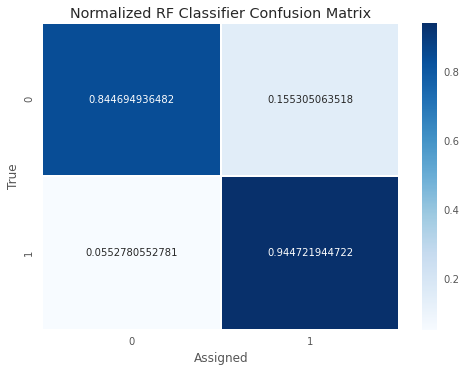

In [124]:
plot_conf_matrix(y5eval,map(int,eval_pred_5class.mean(axis=1)))

In [1]:
plot_conf_matrix(y5eval,map(int,eval_pred5class_100A.mean(axis=1)))

NameError: name 'plot_conf_matrix' is not defined

(0, 1.01)

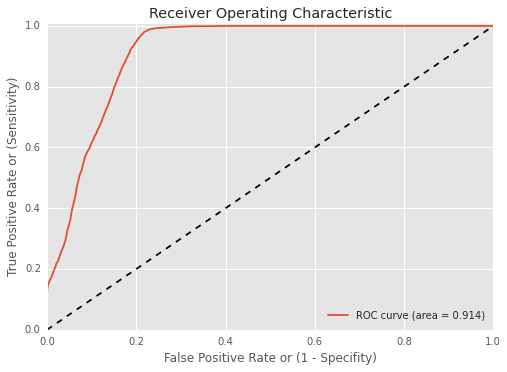

In [178]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,eval_pred5proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [125]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

0.705909774219


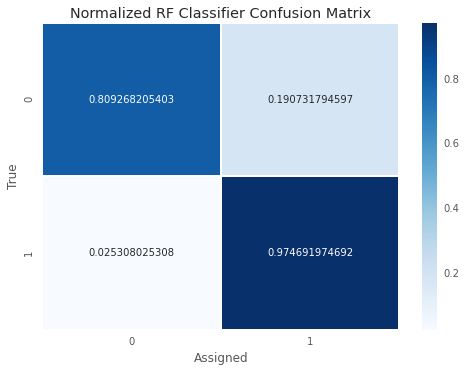

In [127]:
plot_conf_matrix(y5eval,map(int,eval_pred_5class.mean(axis=1)+0.3))

In [130]:
from sklearn.externals import joblib
joblib.dump(five_rf_mdl,'five_rf_mdljl.pkl')

['five_rf_mdljl.pkl',
 'five_rf_mdljl.pkl_01.npy',
 'five_rf_mdljl.pkl_02.npy',
 'five_rf_mdljl.pkl_03.npy',
 'five_rf_mdljl.pkl_04.npy',
 'five_rf_mdljl.pkl_05.npy',
 'five_rf_mdljl.pkl_06.npy',
 'five_rf_mdljl.pkl_07.npy',
 'five_rf_mdljl.pkl_08.npy',
 'five_rf_mdljl.pkl_09.npy',
 'five_rf_mdljl.pkl_10.npy',
 'five_rf_mdljl.pkl_11.npy',
 'five_rf_mdljl.pkl_12.npy',
 'five_rf_mdljl.pkl_13.npy',
 'five_rf_mdljl.pkl_14.npy',
 'five_rf_mdljl.pkl_15.npy',
 'five_rf_mdljl.pkl_16.npy',
 'five_rf_mdljl.pkl_17.npy',
 'five_rf_mdljl.pkl_18.npy',
 'five_rf_mdljl.pkl_19.npy',
 'five_rf_mdljl.pkl_20.npy',
 'five_rf_mdljl.pkl_21.npy',
 'five_rf_mdljl.pkl_22.npy',
 'five_rf_mdljl.pkl_23.npy',
 'five_rf_mdljl.pkl_24.npy',
 'five_rf_mdljl.pkl_25.npy',
 'five_rf_mdljl.pkl_26.npy',
 'five_rf_mdljl.pkl_27.npy',
 'five_rf_mdljl.pkl_28.npy',
 'five_rf_mdljl.pkl_29.npy',
 'five_rf_mdljl.pkl_30.npy',
 'five_rf_mdljl.pkl_31.npy',
 'five_rf_mdljl.pkl_32.npy',
 'five_rf_mdljl.pkl_33.npy',
 'five_rf_mdljl.pkl_3

In [132]:
%cd five_rf_mdljl


/home/kesj/work/hrsepara/eda/five_rf_mdljl


In [133]:
frf= joblib.load('five_rf_mdljl.pkl')

In [135]:
Beval_pred_5class, Beval_pred_proba5 = evaluate_models(frf,X5eval)

(0, 1.01)

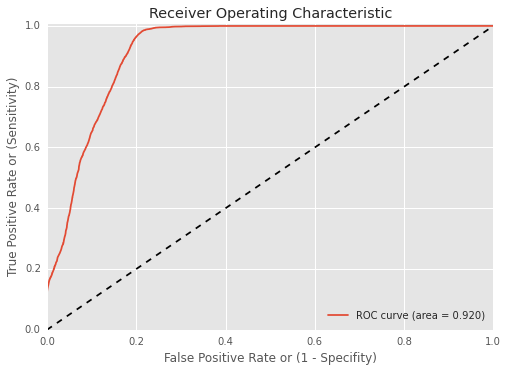

In [136]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,Beval_pred_proba5[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

In [138]:
Beval_pred5class0, Beval_pred5proba0 = evaluate_models(frf[0],X5eval)

In [141]:
Beval_pred_proba5[:,:,0]

array([[ 0.87 ,  0.13 ],
       [ 0.764,  0.236],
       [ 0.57 ,  0.43 ],
       ..., 
       [ 0.83 ,  0.17 ],
       [ 0.39 ,  0.61 ],
       [ 0.   ,  1.   ]])

(0, 1.01)

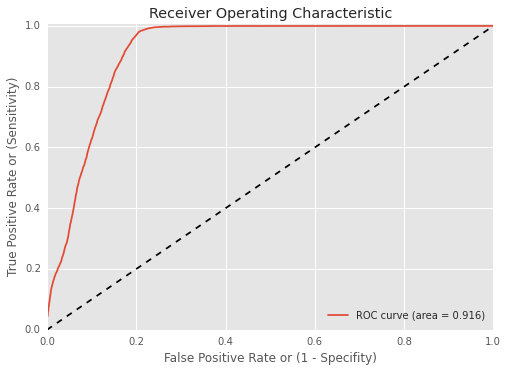

In [146]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,Beval_pred_proba5[:,:,4])
plt.ylim([0,1.01])

## Try again with joblib directly

In [147]:
import joblib as jl

In [148]:
%cd ../
!mkdir jl_5yr


/home/kesj/work/hrsepara/eda


In [152]:
jldir = '/home/kesj/work/hrsepara/eda/jl_5yr/' 
os.chdir(jldir)

## repeat for 3 year

In [179]:
tfold3,tfold3_times,panel3term,X3fold,y3fold = setup_tfold_models(em2mod,3,columns_for_modeling)
print len(tfold3)

13 3 10 107412
11
2002-01-01 2005-01-01 62575 44837
2003-01-01 2006-01-01 60750 46662
2004-01-01 2007-01-01 57564 49848
2005-01-01 2008-01-01 54627 52785
2006-01-01 2009-01-01 53328 54084
2007-01-01 2010-01-01 53138 54274
2008-01-01 2011-01-01 52608 54804
2009-01-01 2012-01-01 53211 54201
2010-01-01 2013-01-01 52587 54825
2011-01-01 2014-01-01 51207 56205
2012-01-01 2015-01-01 50526 56886
11
11


In [180]:
%%time
three_rf_mdl_100 = []
for i in xrange(0,len(tfold3)):
    train_y = y3fold[i].flatten()
    train_X = X3fold[:,:,i]
    rfmdl = ensemble.RandomForestClassifier(n_estimators=100,max_features='auto',n_jobs=1)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    three_rf_mdl_100.append(rfmdl)

CPU times: user 5min 5s, sys: 825 ms, total: 5min 6s
Wall time: 5min 6s


## dump the results

In [181]:
%cd '../'
!mkdir 'jl_3yr_100'
%cd '/home/kesj/work/hrsepara/eda/jl_3yr_100'
three_100_list = jl.dump(three_rf_mdl_100,'trf100.pkl')

/home/kesj/work/hrsepara/eda
/home/kesj/work/hrsepara/eda/jl_3yr_100


In [183]:
len(three_100_list)

5512

In [182]:
X3eval, y3eval = adjust_eval_by_x_years(evalmod,3,columns_for_modeling)

There are 26854 elements in the evaluation set
original target variable value counts: 0    16816
1    10038
dtype: int64
3710 4809 18335
new target variable value counts: 
0    18335
1     4809
dtype: int64
_____
23144 23144
input matrix has 11 features


In [184]:
eval_pred3class,eval_pred3proba = evaluate_models(three_rf_mdl_100,X3eval)

(0, 1.01)

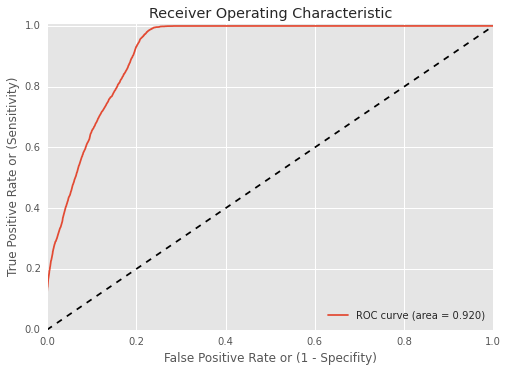

In [185]:
plot_roc_curve(y3eval,eval_pred3proba[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

0.726554507243


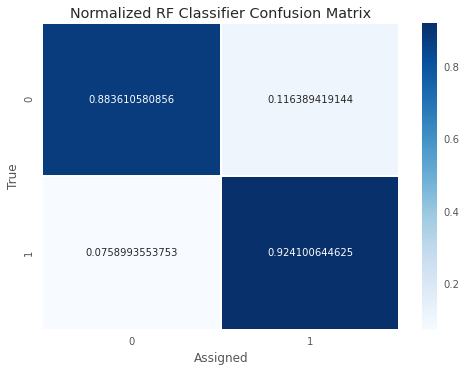

In [187]:
#plot_conf_matrix(y3eval,eval_)
plot_conf_matrix(y3eval,map(int,eval_pred3class.mean(axis=1)))

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
em2[['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1','MAX_RT_ANNUAL']].describe()

In [ ]:
trainDF = em2[minimal_input_col_list].copy()
#non_modeled_columns = trainDF.columns.tolist()
#non_modeled_columns.remove('KEY')
#non_modeled_columns.remove('')

In [ ]:
fixoutliers =Pipeline([ ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],criteria_coef=('percentile',5),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',5),
                                                   method='both',fill_with='nearest_value'))
                      ])


In [ ]:
outlier_trans1 = fixoutliers.fit_transform(trainDF)


In [ ]:
outlier_trans1[['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1','MAX_RT_ANNUAL']].describe()

In [ ]:
### CREATE a preprocessing_pipe and pickle it
preprocess_pipe = Pipeline([ ('drop_unwanted_cols',DropColumns(columns_to_drop = non_modeled_columns )), # drop cols with over 60% missing
                             ('convert_indicators', ConvertToDict(columns_to_fix=['HAVE_INS','HAVE_DEP','INTERN','HUBIND'])), # convert Y->1,N->0
                             ('convert_male', ConvertToDict(columns_to_fix=['SEX'],convert_dict={'M':1,'F':0})), # convert M->1,F->0
                            ('convert_ratings', ConvertToDict(columns_to_fix=['BOX1'],convert_dict={'H':3,'S':2,'L':1})), # convert L->1,S->2,H->3
                              ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],criteria_coef=('percentile',5),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',5),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','MERIT1','PERF1'],rows_to_scan=0.8)),
                            #FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 #("imp_mode",br.ImputeData(columns_to_impute=['MERIT1','PERF1','ADDRCNT1'],rows_to_scan=0.8)),
                 ("imp_mean", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.8))
                           ])


### documentation on pickling
http://scikit-learn.org/stable/modules/model_persistence.html

In [ ]:
%ls

In [ ]:
import time as time
current_time = time.localtime()
print time.strftime('%Y-%m-%d', current_time)

In [ ]:
empl_type_dummy = pd.get_dummies(em2002['EMPL_TYPE'],prefix='EMPL_TYPE',dummy_na=True,columns=['EMPL_TYPE'])

In [ ]:
# now drop one of these
em2002.EMPL_TYPE.value_counts() 
# a forget it

In [ ]:
empl_type_dummy.columns.tolist()

### I want to create a model based upon em2 that only uses the columns listed in my python script
* cols_to_keep = ['KEY','HIRE_DT','BIRTHDATE','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']

In [ ]:
cols_to_keep =  ['KEY','HIRE_DT','BIRTHDATE','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP','TERMINATION_DT']
emplsm = em2002[cols_to_keep].copy()

In [ ]:
sum(emplsm.HIRE_DT.isnull())

In [ ]:
emplsm[['hire_tstmp','birth_tstmp','term_tstmp']] = emplsm[['HIRE_DT','BIRTHDATE','TERMINATION_DT']].applymap(lambda x: pd.to_datetime(datetime.strptime(x,'%d%b%Y')))
#emplsm[['Age_years','Tenure_years']] = emplsm[['birth_tstmp','hire_tstmp']].applymap(lambda x: calculate_years(x,today_timestamp))


## Next step is to build the model
* wait I think I already transformed everthing properly

In [ ]:
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs
    

## Begin by loading the source dataframe file
#### filename is employee_dataframe9.tsv
#### This has been modified from employee_dataframe.ssv in the following ways.
* negative TOT_MO_SERVICE_SFI have been removed
* GRADE = 'UNS', '' have been removed
* STATE_LOC of 'ON' have been removed
* 'retired' have been identified from the ACTRES1 messages.
* Benefits (i.e. have_ins and have_dep) info has been joined into this dataset.
    1. missing values zeroed out 
* unempl_rate (at time of departure or current date) applied
* Some features (columns) cleaned and encoded by scikitlearn label encode (N--> 0, Y-->1):
    1. POSTAL_SFI --> zip5
    2. VOLINVOL --> sep_status (0,1,2,3)
    3. MAR_STA_SNAME_SFI --> mar_status (0,1,2)
    4. SEX --> Male (1,0): M=1,F=0
    5. COMP_FREQUENCY --> hourly_comp (1,0): H=1, A = 0
    6. RATE* using the dictionary provided by Ron Davis to 3 levels: low, medium, High
    7. BOX* columns using this mapping: BOX columns:  L -> 1, S -> 2, H -> 3
        -- still need to apply the mapping of missing to 0.
    8. FLSA_STATUS: map N: 0, Z: 1, X: -1
    9. SHIFT: map 'N' to 0; rest same (arity=4)

In [ ]:
datafile = 'employee_dataframe9.tsv'
empl_bene = pd.read_csv(datafile,sep='\t',dtype={'KEY':np.str,'zip5':np.str,'SKEY':np.str})
empl_bene.drop('Unnamed: 0',axis=1,inplace=True)
# drop per_org --> universally EMP
empl_bene.drop('PER_ORG',axis=1,inplace=True)
print empl_bene.shape

In [ ]:
empl_bene.unempl_rate.hist(bins=40)

### Fix the BOX columns missing values as 0
* note I may want to remove this step from this place in the workflow and let bear fix it

In [ ]:
## Fix the BOX columns missing as 0
box_col_list = [x for x in empl_bene.columns if x.startswith('BOX')]
#empl_bene[box_col_list].fillna(0,inplace=True)#.head()
# replace the boxes with 0 
#chg_to_zero_cols = ['BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
#for box_col in box_col_list: #chg_to_zero_cols:
#    empl_bene.fillna({box_col: 0},inplace=True)

## remove Rows (i.e. employees ) corresponding to certain characteristics
1. keep only those that are known (vol,invol, not) per discussion on April 22, 2015
2. remove grades starting with 'L' and 'AT'
    * As we discussed, I'm already excluding seasonal employees, interns, and agency interns. 
    * Let’s also exclude the L-Level executive employees are in the LDSH job group with job grades L1 to L10 (i.e., all job grades starting with “L”). 
    * Let’s also exclude Air Transportation as we don’t foresee applying the model to them either. Their job group is AIRT with job grades AT1 to AT8 (i.e., all job grades starting with “AT”).
3. take a time slice --> only after 01-01-2002
 



In [ ]:
# remove sep_status over 1
empl_bene = empl_bene[empl_bene.sep_status<=2]
print np.shape(empl_bene)

In [ ]:
# remove AT* and L* grades
list_of_grades = empl_bene.GRADE.unique()
print len(list_of_grades)
grades_to_drop = [x for x in map(str,list_of_grades) if (x.startswith('L') or x.startswith('AT'))]
print len(grades_to_drop)
grades_to_drop.remove('LS2')
grades_to_drop.remove('LS1')
grades_to_drop.remove('LS3')
grades_to_drop.remove('LM1')
grades_to_drop.remove('LM2')
grades_to_drop.remove('LP1')
print len(grades_to_drop),grades_to_drop

In [ ]:
print "removing these {0} grades removes {1} employees".format(len(grades_to_drop),len(empl_bene[empl_bene.GRADE.isin(grades_to_drop)]))
empl=empl_bene[~empl_bene.GRADE.isin(grades_to_drop)].copy()
print np.shape(empl)

### Create a column for terminated (i.e separated but not Retired)
* requires that status == 1 but retired == 0

In [ ]:
## create a column for terminated (i.e. separated but NOT retired)
empl['terminated']= 0
my_rows = empl[(empl.status==1) & (empl.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(empl),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
empl.loc[my_rows,'terminated']=1
print sum(empl.terminated)

In [ ]:
pd.crosstab(empl.status, empl.retired)

## the one case where the person is 'retired' but has status of 0 is wrong -- I'm removing this row.

In [ ]:
wrong_status_idx = empl[(empl.status == 0)& (empl.retired == 1)].index[0]
print wrong_status_idx

In [ ]:
empl.drop(empl.index[wrong_status_idx],inplace=True)
print np.shape(empl)

## Create subset that is based upon those after a given date
specifically January 1, 2002

In [ ]:
date0 = '2002-01-01'
em2002 = empl.ix[empl.TERMINATION_DT>=date0].copy()
print date0, len(em2002)
print "--------- STATUS "
print em2002.status.value_counts()
print "--------- TERMINATED"
print em2002.terminated.value_counts()
print "--------- RETIRED"
print em2002.retired.value_counts()
print np.shape(em2002)

# Tweak some of the columns
1. convert tenure_months into tenure Years  and drop the tenure_months columns. Tenure in years is just easier to think about.
2. create timestamps for columns that are timestamps 
3. create a value for the age at hire (hire_age)

In [ ]:
print np.shape(em2002)
em2002['Tenure_years'] = em2002['Tenure_months']/12.
em2002.drop('Tenure_months',axis=1,inplace=True)


In [ ]:
## create timestamps for columns that are timestamps
em2002[['hire_tstmp','term_tstmp','birth_tstmp']] = em2002[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x:pd.to_datetime(x))
## add a column for age at hire date
hire_age_tdelta = em2002['hire_tstmp']-em2002['birth_tstmp']
# convert to days, months, or years
em2002['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')



###Assign random indices to this data frame

In [ ]:
list_of_indices = list(range(em2002.KEY.nunique()))
print len(list_of_indices )
random.seed(833311)
#new_indices = [x for x in random.shuffle(list_of_indices)
random.shuffle(list_of_indices)#, len(list_of_indices))
em2002.index = list_of_indices # note that random.shuffle does this shuffling inplace
em2002.sort_index(inplace=True)
em2002.head()

# Begin to Step through with BEAR for analysis
1. list all the columns
2. identify columns that I don't want to include in the analysis
3. Identify columns that require further refinement
    * missing values
    * categorical
    * survival function
4. create test-train split (hold out eval set)

In [ ]:
all_cols= em2002.columns.tolist()
len(all_cols)

In [ ]:
columns_with_missing1 = br.get_columns_with_nulls(em2002,rows_to_scan='all')
print len(columns_with_missing1)

In [ ]:
numeric_cols = br.get_numeric(em2002)
categorical_cols = br.get_categorical(em2002)
print len(numeric_cols)+len(categorical_cols), len(numeric_cols),len(categorical_cols)

In [ ]:
time_stamp_cols = list(set(all_cols) - set(categorical_cols)-set(numeric_cols))
time_stamp_cols

#### partitioning of the columns
* 193 columns (all_cols)
    - 3 are timestamps
    - 154 are numeric
    - 36 are categorical
* 69 have missing values (columns_with_missing1)

### Define some columns that I don't want (typically have high number of missing values or are superfluous)
* ADDRESS*, ACTRES*, LOC_CITY, MAR_STATUS_DT, KEY

In [ ]:
columns_to_omit = [a for a in em2002.columns if a.startswith('ACTRES')]
columns_to_omit.append('ADDRESS1')
columns_to_omit.append('ADDRESS2')
#columns_to_omit.append('MAR_STATUS_DT')
columns_to_omit.append('KEY')
columns_to_omit.append('SKEY')
columns_to_omit.append('STATE') # these values are noisier than LOC_STATE
columns_to_omit.append('LOC_CITY')
columns_to_omit.append('zip5')
print len(columns_to_omit)

## collect time-related columns into several groups:
* months of service
* dates
* tdelta
* useful timestamps
* tenure, age


In [ ]:
mos_cols = [x for x in em2002.columns if x.endswith('MOS')]
print len(mos_cols), mos_cols
#tstmp_cols = [x for x in em2002.columns if x.endswith('tstmp')]
#print len(tstmp_cols), tstmp_cols
date_cols = [x for x in em2002.columns if x.endswith('DT')]
date_cols.append('BIRTHDATE')
date_cols.append('Tenure_tdelta')
date_cols.append('Age_tdelta')
print len(date_cols), date_cols
useful_time_cols = []
useful_time_cols.append('Tenure_years')
useful_time_cols.append('Age_years')
useful_time_cols.append('hire_age')
print len(useful_time_cols), useful_time_cols
# remove "MAR_STATUS_DT" from date_cols

In [ ]:
# reduce numeric and categorical by those that are superfluous
all_cols2 = list(set(all_cols)-set(columns_to_omit)- set(date_cols))
print "Now there are {0} total columns to consider.".format(len(all_cols2))

In [ ]:
cols_categorical = br.get_categorical(em2002[all_cols2])

cols_numeric = br.get_numeric(em2002[all_cols2])

cols_missing = br.get_columns_with_nulls(em2002[all_cols2],rows_to_scan='all')
print "This leaves {0} categorical columns, {1} numeric columns and {2} columns with missing data".format(len(cols_categorical),len(cols_numeric),len(cols_missing))

In [ ]:
numeric_to_impute = br.get_columns_with_nulls(em2002[cols_numeric])
missing_categorical = br.get_columns_with_nulls(em2002[cols_categorical],rows_to_scan='all')
print len(numeric_to_impute),len(missing_categorical)

In [ ]:
missing_categorical

# Deal with the categorical columns
###1. describe their features and sparcity
###2. assign missing values for the missing ones
    * GRADE, JOB_FUNCTION to XXX
    * LOC_STATE to XX
    * JOB_FAMILY to XXXX
    * LOC_TYPE_DESCR_SFI to UNKNOWN LOCATION TYPE
###3. convert select columns that are already numeric into categorical 
    * FLSA_STATUS, FUNC_ID_SFI, EXT_FUNC_ID_SFI, FLOR_SFI, COMPANY, DIVISION_CODE_SFI, ETHNIC_GROUP, JOBCODE

In [ ]:
br.get_percentage_of_nulls_pd(em2002[cols_categorical])

In [ ]:
br.describe_categorical(em2002[cols_categorical])

### 2. Go ahead and assign missing values for the categorical ones that are missing 

In [ ]:
em2002['LOC_STATE'].fillna('XX',inplace=True)
em2002['GRADE'].fillna('XXX',inplace=True)
em2002['JOB_FAMILY'].fillna('XXXXX',inplace=True)
em2002['LOC_TYPE_DESCR_SFI'].fillna('UNKNOWN LOCATION TYPE',inplace=True)
em2002['JOB_FUNCTION'].fillna('XXX',inplace=True)

###3. Look at numeric ones that should be considered categorical



In [ ]:
other_categorical = ['FUNC_ID_SFI','EXT_FUNC_ID_SFI','FLOR_SFI','COMPANY','DIVISION_CODE_SFI', 'JOBCODE','ETHNIC_GROUP']
# remove these from numeric_cols

#### redefine my categorical cols to include these


In [ ]:
#augment with the 'other categorical' ones from numerical
cols_categorical2 = []
cols_categorical2 += cols_categorical
cols_categorical2 +=other_categorical
for c in other_categorical:
    cols_numeric.remove(c)
print len(cols_categorical2),len(cols_numeric)
#drop LEGACY_DEPT_CD, company 
#cols_categorical.remove('LEGACY_DEPT_CD')

In [ ]:
em2002[['SAL1','ANNUAL_RT']].corr()

In [ ]:
cols_to_omit_2 = []
cols_to_omit_2.append('TOT_MO_SERVICE_SFI')
cols_to_omit_2.append('LEGACY_DEPT_SFI')
cols_to_omit_2.append('COMPANY')
cols_to_omit_2.append('ANNUAL_RT')


In [ ]:
rate_col_list = [c for c in em2002.columns if c.startswith('RATE')]
box_rate_list = []
box_rate_list +=box_col_list
box_rate_list += rate_col_list
sns.heatmap(em2002[box_rate_list].corr())

Observation: the RATES are more closely correlated that the BOXES -- not that it matters if I only keep the recent values ('1')


### Keep just the most recent values so as to not bias it away from those who have been there longer.


In [ ]:
# get just the most recent values
recentcols = [a for a in all_cols2 if a.endswith('1')]
len(recentcols)

In [ ]:
## define the potential target columns
potential_target_cols = ['status','sep_status','retired','terminated']

# CREATE an evaluation Set
* use test_train_split
# Utilize Pipelines
* restrict the columns that I want to consider
* apply logic to 
    1. fill in missing values
    2. if numeric deal with outliers
    3. if categorical create dummy, factorize (label_encode), or survial_median

In [ ]:
from sklearn import cross_validation
from sklearn.pipeline import Pipeline, FeatureUnion

In [ ]:
# break into evaluation and build sets
print "Starting with subest of {0} employees.".format(len(em2002))
eval_fraction = 0.20
em2, em2eval = cross_validation.train_test_split(em2002,test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2))

In [ ]:
print "For retirement"
print em2.retired.value_counts()/len(em2)
print em2eval.retired.value_counts()/len(em2eval)
print "For Separation"
print em2.terminated.value_counts()/len(em2)
print em2eval.terminated.value_counts()/len(em2eval)


In [ ]:
br.get_columns_with_nulls(em2[recentcols],rows_to_scan='all')

In [ ]:
X.ADDRCNT1.describe()

In [ ]:
X.ADDRCNT1.hist(bins=30)

# some good indicator colums to keep:
* endswith "CNT"
* starts with 'HAVE'
* Male, HUBIND, FTE, DEP_COUNT,  INTERN, MAX_RT_ANNUAL, MIN_RT_ANNUAL,
* RELO_STATE_CNT_SFI

In [ ]:
num_to_keep = [c for c in cols_numeric if c.endswith('CNT')]
num_to_keep.append('HAVE_INS')
num_to_keep.append('HAVE_DEP')
num_to_keep.append('INTERN')
num_to_keep.append('HUBIND')
num_to_keep.append('RELO_STATE_CNT_SFI')
num_to_keep.append('RELOCATE_ALL_SFI')
num_to_keep.append('STD_HOURS')
num_to_keep.append('unempl_rate')
num_to_keep.append('REMOTE')
num_to_keep.append('SUPV_DIFF_LOC')
num_to_keep.append('FTE')
num_to_keep.append('Male')
num_to_keep.append('SHIFT')
num_to_keep.append('FLSA_STATUS')
#num_to_keep.append('mar_status')
num_to_keep.append('REMOTE_SUPV')

num_to_keep.append('hourly_comp')
print len(num_to_keep)
salary_cols = ['MAX_RT_ANNUAL','MIN_RT_ANNUAL']


In [ ]:
not_modeling_cols = list(set(cols_numeric) - set(recentcols) - set(cols_categorical2)-set(useful_time_cols)-set(potential_target_cols)-set(salary_cols) -set(num_to_keep))
print len(not_modeling_cols)
[c for c in not_modeling_cols]
#[c for c in set(cols_numeric) - set(recentcols) - set(other_categorical)-set(useful_time_cols)-set(potential_target_cols)]

In [ ]:
len(num_to_keep), len(salary_cols), len(cols_categorical2), len(potential_target_cols),len(recentcols),len(useful_time_cols),len(cols_categorical)

In [ ]:
num_to_keep

## After all that I'm ready to process the subset of columns contained in these lists:
1. recentcols (19, numeric)
2. salary_cols (2, numeric)
3. useful_time_cols (3,numeric)
4. num_to_keep (21, numeric)
5. cols_categorical2 (18, categorical)
    * note I need to further refine/parse and eliminate some of these

####  Also I want to select from the potential_target_cols my 'y' variable
4 elements, numeric (0 or 1)

In [ ]:
cols_to_model = []
cols_to_model += recentcols
cols_to_model += salary_cols
cols_to_model += useful_time_cols
cols_to_model += num_to_keep
print len(cols_to_model)

## Further refine the categorical ones:
* impute missing values for these

In [ ]:
## Further refine the categorical ones:
print "column, arity, example, type"
[(c,len(em2[c].unique()),em2[c][0],em2[c].dtype) for c in cols_categorical2]

In [ ]:
len(cols_categorical2)

In [ ]:
cat_cols_to_survival = ['JOB_FAMILY','GRADE','JOB_FUNCTION','FLOR_SFI','FUNC_ID_SFI','EXT_FUNC_ID_SFI','JOBCODE']
                        
cat_cols_to_dummy_encode = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME','ETHNIC_GROUP','DIVISION_CODE_SFI','COMPANY']
cat_cols_to_label_encode = ['LOC_TYPE_DESCR_SFI','LOC_STATE']
cat_cols_to_drop = ['LEGACY_DEPT_SFI','LOCATION']

In [ ]:
for c in cat_cols_to_drop:
    cols_categorical2.remove(c)
    #print c, len(em2[c].unique())

In [ ]:
np.shape(em2)

In [ ]:
from sklearn.pipeline import TransformerMixin
class ColumnExtractor(TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def transform(self, X, **transform_params):
        return X[self.columns]

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
from sklearn import preprocessing

In [ ]:
my_cols = []
my_cols+=cols_to_model
my_cols+=cols_categorical2
print len(my_cols)

y = em2['terminated']
X = em2[my_cols]
print np.shape(X)
Xeval = em2eval[my_cols]
print np.shape(Xeval)

In [ ]:
from sklearn.base import BaseEstimator

In [ ]:
class LabelEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self,columns_to_fix=[],rows_to_scan='all'):
        """
        A class that can be inserted into a pipeline
    
        This will replace a given list of columns with label_encoded values;
        
        Parameters
        ----------
        X: Pandas dataframe
        
        
        Note that new categories/values in test data will be set as -1.
        
        returns a pandas dataframe
        """
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        
    def fit(self, X, y=None):
        self.map_values = {}
        self.dummy_values = {}
        self.na_values={}
        
        rows_to_scan_in = br.get_rows_to_scan(self.rows_to_scan, X.shape[0])
        #self.columns_to_fix_in = br.get_list_of_columns_to_check(self.columns_to_fix, X.columns)
        X_temp = X[:rows_to_scan_in].copy()
        # apply labelEncoder to each column in this list
        for col in self.columns_to_fix:
            map_values = X_temp[col].unique()
            map_values.sort()
            self.map_values[col] = {key: index for index, key in enumerate(map_values)} 
        return self
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        for col in self.columns_to_fix:
            X_temp[str(col)+"_le"] = X_temp[col].map(self.map_values[col], "ignore")
            X_temp[str(col)+"_le"] =  X_temp[str(col)+"_le"].fillna(-1)
            # fill all remaining null values with -1
            # remove the original column name and add the new column name
            original_cols.remove(str(col))
            original_cols.append(str(col+"_le"))
        X_temp =X_temp[original_cols]
        
        return X_temp

In [ ]:
class DummyEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self,columns_to_fix=[],rows_to_scan='all',keep_dummies=False):
        """
        A class that can be inserted into a pipeline
    
        This will replace a given list of columns with label_encoded values;
        
        Parameters
        ----------
        X: Pandas dataframe
        
        keep_dummies: boolean (default = False)
            If False then the original dummied column and one of the one-hot-encoded (dummified) columns will be dropped.
            
        Note that new categories/values in test data will be set as -1.
        
        returns a pandas dataframe
        """
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.keep_dummies = keep_dummies
        
    def fit(self, X, y=None):
        #self.map_values = {}
        self.dummy_values = {}
        #self.na_values={}
        
        rows_to_scan_in = br.get_rows_to_scan(self.rows_to_scan, X.shape[0])
        #self.columns_to_fix_in = br.get_list_of_columns_to_check(self.columns_to_fix, X.columns)
        X_temp = X[:rows_to_scan_in].copy()
        # apply labelEncoder to each column in this list
        for col in self.columns_to_fix:
            self.dummy_values[col] = X_temp[col].unique()    
        return self
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        """
        for col in self.columns_to_fix:
            tmp = pd.get_dummies(X[col],prefix=str(col))
            X_temp = pd.concat([X_temp,tmp],axis=1)
            # now drop the columns that I don't want if so flagged
            if not self.keep_dummies:
                X_temp.drop([col,tmp.columns[-1]],axis=1,inplace=True)
         """  
        for col in self.columns_to_fix:            
            for cat in self.dummy_values[col]:
                cat_col = str(col)+'_'+str(cat)
                if str(cat) == 'nan':
                    X_temp[cat_col] = X_temp[col].isnull().astype(int)
                else:    
                    X_temp[cat_col] = (X_temp[col] == cat).astype(int)
                # append the new column name
                original_cols.append(cat_col)
            # if keep_dummies is false remove the original column name and the last category
            if not self.keep_dummies:
                original_cols.remove(str(col))
                original_cols.pop() #note pop removes the last element from a list
        X_temp =X_temp[original_cols]
        
        return X_temp

In [ ]:
# function to replace missing by a given value
class FillMissingValue(BaseEstimator, TransformerMixin):
    def __init__(self,fill_value = 0,columns_to_fix='all',rows_to_scan='all',keep_dummies = False,fill_inf = True):
        """
        A class that can be inserted into a pipeline
    
        This will replace a given list of columns with label_encoded values;
        
        Parameters
        ----------
        X: Pandas dataframe
        
        
     
        
        returns a pandas dataframe
        """
        self.fill_value = fill_value
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.keep_dummies = keep_dummies
        self.fill_inf = fill_inf
        self.values = {}
        
    def fit(self, X, y=None):
        
        X_temp = X.copy()        
        if self.columns_to_fix == 'all':
            X_temp = X_temp.replace(np.inf, np.nan)
            self.columns_to_fix_in = br.get_numeric(X_temp)
        elif self.columns_to_fix == 'auto':
            X_temp = X_temp.replace(np.inf, np.nan)
            self.columns_to_fix_in = br.get_columns_with_nulls(X_temp, 'all', 'all')            
        else:
            self.columns_to_fix_in = br.get_list_of_columns_to_check(self.columns_to_fix, X.columns)
            self.columns_to_fix_in = [col for col in self.columns_to_fix_in if col in br.get_numeric(X_temp)]
            X_temp[self.columns_to_fix_in] = X_temp[self.columns_to_fix_in].replace(np.inf, np.nan)
        
        self.rows_to_scan_in = br.get_rows_to_scan(self.rows_to_scan, X.shape[0])
        
        # check if the fill_values are a list
        if type(self.fill_value)==list:
            self.values = dict(zip(self.columns_to_fix_in,self.fill_value))
        elif type(self.fill_value)==dict:
            self.values = self.fill_value
        else:
            for c in self.columns_to_fix_in:
                self.values[c]=self.fill_value
                
        return self
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        
        if self.fill_inf:
            X_temp[self.columns_to_fix_in] = X_temp[self.columns_to_fix_in].replace(np.inf, np.nan)
        if self.keep_dummies:
            temp = pd.DataFrame(index=X_temp.index)
            for col in self.columns_to_fix_in:
                temp[(col+'_d')] = X_temp[col].isnull().astype("int")
            X_temp = pd.concat([X_temp, temp], axis=1) 
        original_cols = list(X_temp.columns)
        X_temp = X_temp.fillna(self.values)
        X_temp =X_temp[original_cols]
        
        return X_temp

In [ ]:
pd.get_dummies(X[['FULL_PART_TIME','COMPANY']]).columns

In [ ]:
letest = LabelEncodeColumn(columns_to_fix=['GRADE','LOC_STATE','JOB_FAMILY','FUNC_ID_SFI'])
le_tmp = letest.fit(X,y).transform(testX)

In [ ]:
le_tmp['FUNC_ID_SFI_le'].max(), testX['FUNC_ID_SFI'].max()

In [ ]:
detest = DummyEncodeColumn(columns_to_fix=['EMPL_TYPE','FULL_PART_TIME','COMPANY'])
tmp = detest.fit(X,y).transform(testX)

In [ ]:
[c for c in tmp.columns if c.startswith('EMPL_TYPE')]

In [ ]:
X.EMPL_TYPE.value_counts()

In [ ]:
mthl_tenure_range = np.linspace(0,65,781)

In [ ]:
def calculate_survival_functions_b(df,y, time_col, col_name,num_cutoff = 40,timerange =mthl_tenure_range):
    
    """ Function to generically return a dataframe of survival function, grouped by some categorical column
    inputs:
        df --> database to derive survival functions from
        time_col --> the temporal column to use for SF modeling (Kaplan Meier fitter applied)
        event_col --> the truncated column to use for SF modeling
        col_name --> the column to group up and determine KMF sf for
        num_cutoff --> number of groups to consider
        timerange --> min and max range
    outputs:
        survivalfunc_df --> a data frame that contains survival function.

    other options:
        *frac_cutoff --> the fraction of unique elements that will be kept as separate groups
        *min_size_cutoff --> min size to use for the cutoff.
        * these last two are not implemented
    """
    from lifelines import KaplanMeierFitter
    kmf=KaplanMeierFitter()
    # create example for all cases -- serves as background
    # create a time range
    
    kmf.fit(df[time_col],timeline=timerange,event_observed=y,label='all')
    survivalfunc_df = pd.DataFrame(kmf.survival_function_)
    # groupify the dataframe
    grp_value_counts = df[col_name].value_counts()
    #if frac_cutoff == None:
    #    #by default take 15 %
    #    frac_cutoff = .15 
    #top_n_groups = int(frac_cutoff *len(grp_value_counts))
    #if min_size_cutoff == None:
        # by default 
    # Take the top num_cutoff groups
    #my_grps = grp_value_counts.ix[:num_cutoff].index.tolist() 
    my_grps = grp_value_counts.iloc[:num_cutoff].index.tolist() 
    
    # make a list of elements in each of these groups
    grp_dict = {}
    for grp in my_grps: 
        grp_dict[grp] = df[df[col_name] == grp].index.tolist()
    # loop through grps and create kmf survival function
    for i,jgrp in enumerate(my_grps):
        j_idx = grp_dict[jgrp]
        #print i, jgrp, len(j_idx)
        kmf.fit(df[time_col].ix[j_idx],timeline=mthl_tenure_range,event_observed=y.ix[j_idx],label=str(jgrp))
        survivalfunc_df = pd.concat([survivalfunc_df,kmf.survival_function_],axis=1)
    
    
    return survivalfunc_df

In [ ]:
def return_first_time_survival(sfdf,thresh=0.5):
    from collections import defaultdict
    
    # assign all value to the default
    default_value = sfdf[sfdf['all']<=thresh].index[0]
    median_survival_dict = defaultdict(lambda: default_value)
    for c in sfdf.columns[1:]:
        #print c
        try:
            my_sf_date = sfdf[sfdf[c]<=thresh].index[0]
        except IndexError: # because never reached that threshold value
            my_sf_date = sfdf.index[-1]
        except KeyError: # because of type of the key
            my_sf_date = sfdf[sfdf[int(c)]<=thresh].index[0]

        median_survival_dict[c]=my_sf_date
        
    return median_survival_dict

In [ ]:
class SurvivalEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_fix=[],rows_to_scan='all',method='median',max_number_groups=40, my_thresh=0.5):
        self.method = method
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.max_num_groups = max_number_groups
        self.thresh = my_thresh
        
    def fit(self,X,y):
        self.survive_columns = {} # dictionary to map old columns to new
        self.survive_values = {}
        self.column_cutoff = {}
        
        
        for col in self.columns_to_fix:
            #(assumes these have previously been label encoded so the values should be ints)"
            ncol=str(col)+"_le"
            num_cutoff = self.max_num_groups
            survive_col = 'surv_'+ncol.lower()
            nuniq = len(X[ncol].unique())
            if nuniq < num_cutoff:
                num_cutoff = nuniq
                
            self.column_cutoff[col]=num_cutoff
            
            #frac_accounted_for = X[col].value_counts().iloc[:num_cutoff].sum()/float(len(X))
            #print i,col,newcol, nuniq, num_cutoff,num_cutoff/float(nuniq),frac_accounted_for
            # I want to make this fraction close to 80%?
            sf_df = calculate_survival_functions_b(X,y,'Tenure_years', ncol,num_cutoff)
            self.survive_columns[col]=survive_col
            ## create the dictionary
            self.survive_values[col]=return_first_time_survival(sf_df,thresh=self.thresh)
    
        return self
    def transform(self,X,y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        for col in self.columns_to_fix:
            ncol=str(col)+"_le" # assumes labelencoded
            new_col = self.survive_columns[col]
            col_dict = self.survive_values[col]
            X_temp[new_col] = X_temp[ncol].apply(lambda x: col_dict[str(x)])
            original_cols.remove(ncol)
            original_cols.append(new_col)
        
        X_temp = X_temp[original_cols]
        return X_temp
    

In [ ]:
gsfdf = calculate_survival_functions_b(leX,y,'Tenure_years','GRADE_le',40)
gsfdf.shape

In [ ]:
leX.GRADE_le.apply(lambda x: a[str(x)]).hist()

In [ ]:
# combine cat_cols_label_encode and cat_cols_surv_encode
my_label_encode_cols = []
my_label_encode_cols+=cat_cols_to_survival
my_label_encode_cols+=cat_cols_to_label_encode
print len(my_label_encode_cols)
my_label_encode_cols

In [ ]:

#cate_list = br.get_categorical(X)
# need to break the categorical into types
pipe = Pipeline([("null", br.RemoveAllNull()),  
                 ("label_encode",LabelEncodeColumn(my_label_encode_cols)),
                 ("dummy_encode", DummyEncodeColumn(cat_cols_to_dummy_encode)),
                 ("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 #("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],criteria_coef=('percentile',5),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',5),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=['MERIT1','PERF1','ADDRCNT1'],rows_to_scan=0.8)),
                 ("imp_mean", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.8))])
                 #("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])
#pipe.fit(X, y).transform(testX)[0:30]
#
#Xft = pipe.fit_transform(X)

### Aside --> check on missing value columns

In [ ]:
missing_column_list = br.get_columns_with_nulls(X)
for c in missing_column_list:
    print c,sum(X[c].isnull()),X[c].mode()

In [ ]:
X[['FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT']].describe()

In [ ]:
X.MERIT1.hist(bins=40)

In [ ]:
X.MERIT1.describe()

In [ ]:
X[X.MERIT1<0].MERIT1.describe()

In [ ]:
#br.FixNumericOutlier(columns_to_fix=['MERIT1'],criteria_coef=('percentile',5),
#                                                   method='lower',fill_with='nearest_value')
fixout=br.FixNumericOutlier(columns_to_fix=['MERIT1','PERF1'], criteria_coef=('percentile', 5), 
                            method = 'lower', fill_with='nearest_value')
                            
X1 = fixout.fit(X).transform(X)
print X1[['MERIT1','PERF1']].describe()

In [ ]:
X1.MERIT1.mode()

In [ ]:
time_stamp_cols

In [ ]:
em2.ix[X['ADDRCNT1'].isnull().index][['Age_years','hire_tstmp','term_tstmp']]

In [ ]:
Xft['surv_job_family_le'].hist(bins=30)

#OKAY So NEXT Step is to apply the transformation using my pipe and check for collinearity

In [ ]:
tXeval = pipe.fit(X,y).transform(Xeval)

In [ ]:
Xft = pipe.fit_transform(X,y)

In [ ]:
[c for c in Xft.columns if 'BOX' in c]

In [ ]:
br.perfect_collinearity_test(Xft)

In [ ]:
br.get_initial_analysis(Xft, y, tXeval, rows_to_scan=10000, sample_size=5000, random_state=42, cate_cap=10)

# August 17, 2015
#### At this point I have a pipeline to process the input (and eval) data.

#### here is what it does:
1. labelEncodes the string variables (categorical) that I don't want to get dumped
2. applies a dummy encoding to OneHotEncode categorical varables with less than 18 categories
3. applies a survival function to subset of categorical that I want to do this too
4. 'fixes outliers' in salary related data: SAL1, MIN_RT_ANNUAL MAX_RT_ANNUAL, PERF1,MERIT1
5. imputes missing:
    * BOX1, FUNC_CNT, EXTFUNC_CNT, TOTAL_RPT_CNT, DIRECT_RPT_CNT set to zero
    * PERF1, MERIT1, ADDRCNT1 set to mode (which is zero)
    * others set to mean

In [ ]:
Xft.BOX1.value_counts(), Xft.MERIT1.describe()

## Aug 21, 2015
* I want to drop hire_age (collinear)
* 

In [ ]:
Xft[['PERF1','MERIT1','hire_age','Age_years','Tenure_years']].corr()

In [ ]:
sns.lmplot(x='PERF1',y='MERIT1',data=Xft,line_kws={'color':'k'})

In [ ]:
sns.lmplot(x='Tenure_years',y='Age_years',data=Xft,line_kws={'color':'k'})

In [ ]:
sns.jointplot(x='hire_age',y='Tenure_years',data=Xft)

In [ ]:
minimum_cols = ['Tenure_years','Age_years','MAX_RT_ANNUAL','MIN_RT_ANNUAL','SAL1','HAVE_INS','HAVE_DEP','Male','EMPL_TYPE']

# need to redefine my pipe

In [ ]:
#class to drop a list of columns
from sklearn.base import BaseEstimator,TransformerMixin
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self,columns_to_drop=[]):
        """
        A class that can be inserted into a pipeline
    
        This will drop columns that are listed as input to this class
        
        Parameters
        ----------
        X: Pandas dataframe
        
        
        columns_to_drop: a list of columns to remove from the input DF.
        
        returns a pandas dataframe
        """
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        self.columns_to_drop = self.columns_to_drop
        return self
        
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        for col in X_temp.columns:
            if col in self.columns_to_drop:
                X_temp.pop(col)
        
        return X_temp

In [ ]:
X.columns

In [ ]:
set_minimum_cols= set(minimum_cols)
my_minfix_cols = ['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1']
my_maxfix_cols = ['MAX_RT_ANNUAL']
missing_zero_cols = ['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT']
mode_impute_cols = ['MERIT1','PERF1','ADDRCNT1']
mean_impute_cols = 'auto'



In [ ]:
pipe2 = Pipeline([("null",br.RemoveAllNull()),
                 ("drop",DropColumns(columns_to_drop =['hire_age','unempl_rate'])),  
                 ("label_encode",LabelEncodeColumn(my_label_encode_cols)),
                 ("dummy_encode", DummyEncodeColumn(cat_cols_to_dummy_encode)),
                 ("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),                 
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=my_minfix_cols,criteria_coef=('percentile',5),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_ANNUAL_RT'],criteria_coef=('percentile',5),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",FillMissingValue(columns_to_fix=missing_zero_cols,fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=mode_impute_cols,rows_to_scan=0.8))])
                 #("imp_mean", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.8))])

In [ ]:
Xft_mincols = pipe2.fit_transform(X,y)

In [ ]:
np.shape(Xft_mincols), np.shape(Xft)

In [ ]:
tXeval_mincols = pipe2.fit(X,y).transform(Xeval)

In [ ]:
br.perfect_collinearity_test(Xft_mincols)

In [ ]:
br.get_initial_analysis(Xft_mincols, y, tXeval_mincols, rows_to_scan=10000, sample_size=5000, random_state=42, cate_cap=10)

In [ ]:
minimum_cols

##Try again using just a very small set of columns

In [ ]:
br.get_initial_analysis(X[minimum_cols],y,Xeval[minimum_cols])

In [ ]:
minimal_input_col_list = ['KEY','HIRE_DT','BIRTHDATE','SAL1','HAVE_INS','HAVE_DEP','EMPL_TYPE','Male',
                          'MAX_RT_ANNUAL','MIN_RT_ANNUAL','PERF1','MERIT1','BOX1','INTERN','HUBIND']
empl[minimal_input_col_list].head()

## ASIDE
* looking at info for testdata

In [ ]:
keys_to_get = ['"929965184037557"',
 '"872454415016088"',
 '"247046588569436"',
 '"980835578861104"',
 '"831802700567899"',
 '"612245620047788"',
 '"673774298594228"',
 '"53680010164939"',
 '"361010560468310"',
 '"688423451822448"']

In [ ]:
for a in keys_to_get:
    print a,em2002[em2002.KEY == a.strip('"')][['HAVE_INS','HAVE_DEP']].values

In [ ]:
for a in keys_to_get:
    print a,em2002[em2002.KEY == a.strip('"')][['Male']].values

In [ ]:
for c in em2002[minimal_input_col_list]:
    print c, em2002[c].dtype

In [ ]:
min_col_list = ['KEY','HIRE_DT','BIRTHDATE',
                'SAL1','PERF1','MERIT1','BOX1','MAX_RT_ANNUAL','MIN_RT_ANNUAL',
            'HAVE_INS','HAVE_DEP','EMPL_TYPE','Male',
                          'INTERN','HUBIND']

In [ ]:
em2[min_col_list]

In [ ]:
pipe_small_0 = pipe()

In [ ]:
pipe_categorical_features = Pipeline([ ('factor_encode', br.ConvertCategorical(cat_cols_to_label_encode))])

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('factorize', Pipeline([
            ('extract', ColumnExtractor(cat_cols_to_label_encode)),
            ('factor_encode',br.ConvertCategorical(cat_cols_to_label_encode))                                
            #('scale', Normalizer())
        ])),
        ('dummy', Pipeline([
            ('extract', ColumnExtractor(cat_cols_to_dummy_encode)),
            ('dummy_encode',br.ConvertCategorical(cat_cols_to_dummy_encode,method='dummy'))
            #('one_hot', OneHotEncoder(n_values=5)),
            #('to_dense', DenseTransformer())
        ]))
                    ]))])

In [ ]:
tmp_cols = []
tmp_cols += cat_cols_to_label_encode
tmp_cols += cat_cols_to_dummy_encode
len(tmp_cols), len(cat_cols_to_label_encode)

In [ ]:
pipe_categorical_features = Pipeline(steps=[('tmp_cat_feat', FeatureUnion(transformer_list=[
        ('factor_encode',br.ConvertCategorical(cat_cols_to_label_encode)),
        ('dummy_encode', br.ConvertCategorical(cat_cols_to_dummy_encode,method='dummy'))
        
    ]))])
#ft = categorical_features.fit_transform(em2[tmp_cols])

In [ ]:
#ft = pipeline.fit_transform(em2[tmp_cols])
ft = pipe_categorical_features.fit(em2[tmp_cols],em2['retired']).transform(em2[tmp_cols])

In [ ]:
np.shape(ft), np.shape(em2[tmp_cols])

In [ ]:
pipeline = Pipeline([
    # preprocess the categorical data
    ('subjectbody', SubjectBodyExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('subject', Pipeline([
                ('selector', ItemSelector(key='subject')),
                ('tfidf', TfidfVectorizer(min_df=50)),
            ])),

            # Pipeline for standard bag-of-words model for body
            ('body_bow', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ])),

            # Pipeline for pulling ad hoc features from post's body
            ('body_stats', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'subject': 0.8,
            'body_bow': 0.5,
            'body_stats': 1.0,
        },
    )),

    # Use a SVC classifier on the combined features
    #('svc', SVC(kernel='linear')),
])

## Utilize pipeline to preprocess the categorical data

In [ ]:
pp_category_pipe = Pipeline([("cat_le",br.ConvertCategorical(cat_cols_to_label_encode)),
                            ("cat_dummy",br.ConvertCategorical(['FULL_PART_TIME','COMPANY'],method='value_counts'))])
#("cat_survmed",br.Convert)]
# this is the same as factorize ( I think)


In [ ]:
pipe = Pipeline([("catd", br.ConvertCategorical(cat_cols_to_dummy_encode, method='dummy')),
                 ("catf", br.ConvertCategorical(cat_cols_to_label_encode))])
ft= pipe.fit_transform(em2)
                 #("imp", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.3)),
                 #("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])

In [ ]:
ft = pp_category_pipe.fit_transform(em2)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8*1-.8))
sel.fit_transform(em2[cols_categorical])

In [ ]:
br.get_columns_with_nulls(em2[cols_categorical])

In [ ]:
## create a class for this


In [ ]:
pipe = Pipeline(['impute',])

In [ ]:
# break into X and Xeval groups


In [ ]:
from sklearn.pipeline import Pipeline
cate_list = br.get_categorical_list(X)
pipe = Pipeline([("null", br.RemoveAllNull()),                   
                 ("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("imp", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.3)),
                 ("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])
pipe.fit(X, y).transform(testX)[0:10]

In [ ]:
#### create a new list of cols_to_keep


In [ ]:
#catdummy = br.ConvertCategorical(categorical_columns=[['LOC_STATE','LOC_TYPE_DESCR_SFI']],rows_to_scan='all')
#catdummy.fit(em2, em2['terminated']).transform(em2eval)[0:10]

In [ ]:
for c in em2002[['LOC_STATE','LOC_TYPE_DESCR_SFI']].columns:
    print c
    print len(em2002[c].unique())

In [ ]:

cols_to_survival = ['GRADE','JOB_FAMILY','JOB_FUNCTION','LOCATION']
cols_to_cat_encode = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME']
cols_to_label_encode = ['LOC_TYPE_DESCR_SFI','LOC_STATE']

In [ ]:
#br.get_percentage_of_nulls_pd(em2002)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
my_prob_thresh = .8
sel = VarianceThreshold(threshold=(my_prob_thresh*(1 - my_prob_thresh)))
sel.fit_transform(em2002[['FLSA_STATUS','FLOR_SFI','Male','INTERN']])

## helper functions follow

In [ ]:
def assign_unempl_rate(my_date,unempl):
    try :
        un_rate = unempl[unempl.index <= my_date]['value'].values[-1]
    except IndexError:
        un_rate = unempl['value'].ix[0]
        
    return un_rate

In [ ]:
# function to truncate POSTAL_ZIP to zip5
def truncate_postal_zip(in_zip):
    try:
        out_zip = in_zip[:5]
        #print out_zip
    except:
        #out_zip = str(in_zip)[:5]
        out_zip = np.nan
    return out_zip

In [ ]:
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,sep = ';',dtype_dict = None):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    if dtype_dict != None:
        df = pd.read_csv(inname,sep=sep,dtype =dtype_dict)
    else:
        df = pd.read_csv(inname,sep=sep)
    # clean up local filespace
    !rm {inname}
    return df

In [ ]:
def summarize_dataframe2(df,show_example=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    # assing fraction of missing
    summary_df['x_missing'] = summary_df['nmissing']/float(nrow)
    
    return summary_df

###check on various  encoded variables

* arity = 4, for 'SHIFT' map 'N' --> 0 and make FULL_PART_TIME categorical
* arity = 5 -- make EMPL_TYPE to categorical
* arity = 6, fine
* arity = 7, make COMPANY categorical
* arity = 8,9,10, fine
* arity = 11: EEO1CODE to categorical
* arity = 12: EMPL_CLASS to categorical
* arity = 19: JOB_FUNCTION to categorical

In [ ]:
#sdf[sdf.arity==4]
# dictonary of ratings
ratings_dict = {}
high_ratings = ['R3C3','R3C2','L3EXC','L3-EXC','OTSD','L3PRO','L3-PRO',
                'EXCELS','SUPR','EXC/SUS','EXC/IMP','PEXE','ME - MEETS']
low_ratings = ['IMPR','L1INC','L1DEV','L1PRO','NTAC','R1C2','R1C3','INC/DEC',
               'INC/SUS','INC/IMP','INCNSSTE','L1EXC','UNAC','R1C1','L2-INC','L2INC',
               'L1-EXC','L1-PRO','BEXP','L1-DEV','L1-INC','DNM - DOES','R3C1','R2C1']
solid_ratings = ['R2C3','R2C2','L2EXC','L2PRO','EXPE','/EX/','COMM','AOBJ','EXC/DEC',
                 'PRO/IMP','PRO/SUS','PRO/DEC','SM - SUCCE','MS - MEETS','L2DEV','L3INC',
                 'L3DEV','L2-DEV','L3-INC','ACPT','L3-DEV','L2-EXC','L2-PRO']

# initialize
for rating in high_ratings:
    ratings_dict[rating] = 3
for rating in low_ratings:
    ratings_dict[rating]=1
for rating in solid_ratings:
    ratings_dict[rating]=2


# function for assigning
def assign_simple_rating(x,my_dict = ratings_dict):
    try:
        rval = my_dict[x.strip()]
    except KeyError:
        rval = 0
    except AttributeError:
        rval = 0
    return rval

In [ ]:
### For Rate replace solid with 2, High with 3, Low with 1
#rate_col_list = [x for x in empl_bene.columns if x.startswith('RATE')]
#print len(rate_col_list)
#empl_bene[rate_col_list] = empl_bene[rate_col_list].applymap(lambda x: assign_simple_rating(x))
##empl[rate_col_list] = empl[rate_col_list].map(lambda(x): assign_simple_rating(x)).copy()
#empl_bene[rate_col_list].head()

In [ ]:
cat_description = br.describe_categorical(em2002[cols_categorical])
cat_description

In [ ]:
em2002[['SAL1','SAL2']].corr()

In [ ]:
em2002['SAL2'].describe()

In [ ]:
len(numeric_to_impute)

In [ ]:
numeric_to_impute

In [ ]:
len(list(set(cols_numeric) - set(mos_cols) - set(useful_time_cols) - set(potential_target_cols)-set(numeric_to_impute)))

In [ ]:
[c for c in list(set(cols_numeric) - set(mos_cols) - set(useful_time_cols) - set(potential_target_cols)-set(numeric_to_impute))]

In [ ]:
em2002[['TOT_MO_SERVICE_SFI','Tenure_years']].corr()

In [ ]:
em2002['FLOR_SFI'].value_counts()

In [ ]:
em2002['INTERN'].value_counts()

In [ ]:
em2[recentcols].describe()

In [ ]:
br.get_percentage_of_nulls_pd(em2,recentcols)

## Attempt to apply pipeline logic

In [ ]:
len(em2build.columns)

In [ ]:
fixzero=br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL'], criteria_coef=('percentile', 10), 
                            method = 'lower', fill_with='nearest_value')#,   
fixboth = br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef =('percentale',10),
                              method='both',fill_with='nearest_value')

In [ ]:
pipe0 = Pipeline('extract_cols', selectColumns(),
                'fixzero', fixzero(),
                'fixboth',fixboth(),
                'impute_numeric',br.ImputeData(columns_to_impute=['MERIT1','PERF1','ADDRCNT'])

In [ ]:
class selectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, )

In [ ]:
class RemoveAllNull(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_check='all'):
        """
        A class that can be inserted into pipeline.
        This will remove the columns with all missing values in the columns_to_check
        
        Parameter:
        ----------
        columns_to_check: string or list, optional (default="all")
            If "all", check all columns. Other 
            strings are interpreted to represent column names and you can 
            pass a list of column names to check.
        -----------
        
        returns a pandas dataframe
        """
        self.columns_to_check = columns_to_check
    
    def fit(self, X, y=None):
        self.columns_to_remove = get_columns_with_all_nulls(X, self.columns_to_check)
        return self
    def transform(self, X, y=None):
        X_temp = X.copy()
        for col in X_temp.columns:
            if col in self.columns_to_remove:
                X_temp.pop(col)
        return X_temp

In [ ]:
from sklearn.pipeline import Pipeline,FeatureUnion

In [ ]:
pipe0 = Pipeline(['col_drop', ])

In [ ]:
feature_extraction0 = FeatureUnion(['med_surv',medianSurvival(),
                                   'continuous',])
pipeline0 = Pipeline([
  ('extract_essays', EssayExractor()),
  ('features', FeatureUnion([
    ('ngram_tf_idf', Pipeline([
      ('counts', CountVectorizer()),
      ('tf_idf', TfidfTransformer())
    ])),
    ('essay_length', LengthTransformer()),
    ('misspellings', MispellingCountTransformer())
  ])),
  ('classifier', MultinomialNB())
])

In [ ]:
fixrate1 = br.FixNumericOutlier(columns_to_fix = ['MIN_RT_ANNUAL','']

In [ ]:
from sklearn.pipeline import Pipeline
cate_list = br.get_categorical_list(X)
pipe = Pipeline([("null", br.RemoveAllNull()),                   
                 ("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("imp", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.3)),
                 ("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])
pipe.fit(X, y).transform(testX)[0:10]

## Step through the DF with bear
1. list all columns
2. find those that have all nulls
3. find those that have any missing

In [ ]:
# check if any column has all missing
chk_for_null_columns = br.get_columns_with_all_nulls(empl_bene)
if len(chk_for_null_columns) > 0:
    print "WARNING there are {0} columns that are completely null.".format(chk_for_null_columns)
    print chk_for_null_columns
    empl_bene.drop(chk_for_null_columns,axis=1,inplace=True)
else:
    print "there were no columns that were universally null."
    


# encode some categorical

In [ ]:
# identify the columns with missing data
cols_with_missing_data = br.get_columns_with_nulls(empl_bene)
if len(cols_with_missing_data)==0:
    print "there were no columns with missing data."
else:
    print "WARNING there are {0} columns that have missing data.".format(len(cols_with_missing_data))
    print "These columns are:\t",cols_with_missing_data

In [ ]:
# Partition these with missing values into categorical/boolean/numeric
all_numeric_cols = br.get_numeric(empl_bene)
all_cat_cols = br.get_categorical(empl_bene)
print len(all_numeric_cols),len(all_cat_cols)

In [ ]:
## which columns are numeric and have missing?
print len(list(set(all_numeric_cols).intersection(set(cols_with_missing_data))))
print len(list(set(all_cat_cols).intersection(set(cols_with_missing_data))))

In [ ]:
sdf.sort('nmissing',ascending=False)

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder() #assigns unique integers to values base upon alphabetical order.

In [ ]:
boolean_cols = sdf[(sdf.arity==2) & (sdf.datatype=='object')].Column.values
print boolean_cols
for c in boolean_cols:
    print c, sdf[sdf.Column==c]['accepted values']

In [ ]:
for col in boolean_cols:
    empl_bene[col] = label_encoder.fit_transform(empl_bene[col]) # use sklearn.preprocesing.LabelEncoder()



In [ ]:
[a for a in em2002[em2002.FULL_PART_TIME_X==1].columns if a.endswith('months')]
em2002[em2002.FULL_PART_TIME_X==1].Tenure_months.describe()#hist(normed=True)
#em2002[em2002.FULL_PART_TIME_X!=1].Tenure_months.hist(normed=True)

In [ ]:
em2002[em2002.FULL_PART_TIME_X==0].Tenure_months.describe()

In [ ]:
empl_bene.FULL_PART_TIME.value_counts(), empl_bene.EMPL_TYPE.value_counts()

In [ ]:
cols_to_categorical_1 = br.get_categorical(em2002[cols_to_consider1])
for c in cols_to_categorical_1:
    print c, len(em2002[c].unique()), sum(em2002[c].isnull())

In [ ]:
def create_factorized_df(input_df,column_name):
    tmp_df = pd.get_dummies(input_df[column_name],prefix=column_name)
    # now drop the largest category
    lgst_category = input_df[column_name].value_counts().index[0]
    #print tmp_df.shape, tmp_df.columns
    #print lgst_category
    base_category = column_name+'_'+str(lgst_category)
    tmp_df.drop(base_category,axis=1,inplace=True)
    print tmp_df.shape, base_category
    return tmp_df,base_category

In [ ]:
missing_cols2_as_floats =[]
missing_cols2_as_cats = []
for c in list_with_missing2:
    my_dtype = em2002[c].dtype
    
    if my_dtype == np.float64:
        
        missing_cols2_as_floats.append(c)
    else:
        print c, sum(em2002[c].isnull()), em2002[c].dtype
        missing_cols2_as_cats.append(c)
        
print len(missing_cols2_as_floats)

In [ ]:
em2002['LOC_STATE'].fillna('XX',inplace=True)
em2002['GRADE'].fillna('XXX',inplace=True)
em2002['JOB_FAMILY'].fillna('XXXXX',inplace=True)
em2002['LOC_TYPE_DESCR_SFI'].fillna('UNKNOWN LOCATION TYPE',inplace=True)
em2002['JOB_FUNCTION'].fillna('XXX',inplace=True)
cols_to_survival = ['GRADE','JOB_FAMILY','JOB_FUNCTION','LOCATION']
cols_to_cat3 = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME']
cols_to_label_encode = ['LOC_TYPE_DESCR_SFI','LOC_STATE']

em2002.drop('LEGACY_DEPT_SFI',axis=1,inplace=True)



In [5]:
.45*2508, .70*1500

(1128.6000000000001, 1050.0)

In [ ]:
# create a dummified dataframe.
base_category_list =[]
dummy_categories_list = []
print em2002.shape
for acol in cols_to_cat3:
    print acol
    t_df,bc1 = create_factorized_df(em2002,acol)
    # drop the original column
    #new_col_names = t_df.columns.tolist()
    #dummy_categories_list+=new_col_names
    em2002.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    em2002 = pd.concat([em2002,t_df],axis=1)
    base_category_list.append(bc1)

print em2002.shape,len(base_category_list)

In [ ]:
base_category_list

In [ ]:
for acol in cols_to_cat3:
    #if acol != 'EMPL_CLASS':
    cols_to_consider1.remove(acol)
    added_cols = [x for x in em2002.columns if x.startswith(acol)]
    cols_to_consider1+=added_cols
cols_to_consider1.remove('LEGACY_DEPT_SFI')
len(cols_to_consider1)

In [ ]:
## Label Encode those 2 columns: LOC_STATE and LOC_TYPE_DESCR_SFI
for acol in cols_to_label_encode:
    label_encoder.fit_transform(em2002[acol])

In [ ]:
[x for x in cols_to_consider1 if 'FUNC_ID' in x]
# add these to the cols_to_survival

In [ ]:
em2002.EXT_FUNC_ID_SFI.isnull().sum()

In [ ]:
print len(em2002.FUNC_ID_SFI.unique()), len(em2002.EXT_FUNC_ID_SFI.unique())
cols_to_survival.append('FUNC_ID_SFI')
cols_to_survival.append('EXT_FUNC_ID_SFI')
cols_to_survival


In [ ]:
my_list_of_missing_cols = br.get_columns_with_nulls(em2002[cols_to_consider1])
missing_counts_cols = [x for x  in my_list_of_missing_cols if 'CNT' in x]
print missing_counts_cols


In [ ]:
# make these 'counts' go to -1 for missing
for acolumn in missing_counts_cols:
    em2002.fillna({acolumn: -1},inplace=True)


In [ ]:
my_list_missing_2 = br.get_columns_with_nulls(em2002[cols_to_consider1])
print len(my_list_missing_2)

In [ ]:
[x for x in em2002.columns if x.startswith('EMPL_CLASS')]

In [ ]:
class ColumnExtractor(TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def transform(self, X, **transform_params):
        return X[self.columns]

    def fit(self, X, y=None, **fit_params):
        return self

## Correct values for the floats:
* if min value (MIN_RT_ANNUAL)
    * is zero reset to min value
    * is nan reset to median?
* if max value  (MAX_RT_ANNUAL) is 
    * zero reset to min value
    * nan reset to median?
    
#### examine how many of these are the cases

In [ ]:
print sum(em2002.MAX_RT_ANNUAL <= 1), sum(em2002.ANNUAL_RT <= 1), sum(em2002.MIN_RT_ANNUAL<=1)

In [ ]:
my_value = 0
salary_cols = ['MIN_RT_ANNUAL','MAX_RT_ANNUAL','ANNUAL_RT']
for col in salary_cols:
    #my_mtd = 'max'
    my_data = em2002[em2002[col]!=my_value][col]
    print col, my_data.min(), my_data.max(), my_data.mean(), my_data.median()
#em2002[em2002['MAX_RT_ANNUAL']!=my_value]['MAX_RT_ANNUAL'].median()

In [ ]:
print len(em2002[em2002['ANNUAL_RT']==0])#['ANNUAL_RT'].value_counts()

In [ ]:
em2002[em2002['MAX_RT_ANNUAL']<999999]['MAX_RT_ANNUAL'].max()

In [ ]:
em2002[em2002['ANNUAL_RT']==0][['BIRTHDATE','TERMINATION_DT','HIRE_DT','GRADE','MAX_RT_ANNUAL']]#[cols_to_consider1]

In [ ]:
[a for a in em2002.GRADE.unique() if a.startswith('C')]

In [ ]:
len(em2002[em2002.GRADE == 'C23'][['TERMINATION_DT','ANNUAL_RT']])

## NOW to define the imputation approaches
* by Mean/median/min?
* by Survival function
* by counts

In [ ]:
most_recent_missing_col = [ c for c in my_list_missing_2 if c.endswith('1')]
most_recent_missing_col

In [ ]:
## Now I need to split into build-eval set

In [ ]:
em2002.terminated.value_counts()

In [ ]:
print len(em2002.columns)
cols_to_survival

In [ ]:
print len(columns_to_omit), len(columns_to_omit_2)
columns_to_omit_2

In [ ]:
cols_to_label_encode.append('COMPANY')

In [ ]:
set(em2002.columns.tolist()) - set(columns_to_omit_2)

In [ ]:
len(cols_to_consider1), len(my_list_missing_2)

In [ ]:
[(a,em2002[a].isnull().sum(), em2002[a].median(), em2002[a].mean()) for a in my_list_missing_2]

## Use cols_to_consider1
* Create a test train split
* then use pipelines for the following
* try to apply class that adjusts the missing values in my_list_missing_2 to median?
* try to apply class that adjusts the zero values of 

In [ ]:
columns_to_omit_2

In [ ]:
#replace in the cols_to_consider list
cols_to_consider = [a for a in cols_to_consider1 if not a.startswith('Tenure')]
print len(cols_to_consider),len(cols_to_consider1)
cols_to_consider.append('Tenure_years')

## Label encode the 3 like that
* and alter the cols_to_consider listing

In [ ]:
for col in cols_to_label_encode:
    newcol = 'le_'+col.lower()
    cols_to_consider.remove(col)
    cols_to_consider.append(newcol)
    print col,newcol
    em2002[newcol] = label_encoder.fit_transform(em2002[col]) # use sklearn.preprocesing.LabelEncoder()

print len(cols_to_consider)
cols_to_consider[-8:]

In [ ]:
# split the training data into two parts
from sklearn.cross_validation import train_test_split
emBuild, emEval = train_test_split(em2002, test_size=0.25, random_state=92)

In [ ]:
print np.shape(emBuild), np.shape(emEval)

In [ ]:
# reset the indices of these two sets and the dates
emBuild_dates = empl_dates.ix[emBuild.index].copy()
emEval_dates = empl_dates.ix[emEval.index].copy()
#build_indices = emBuild.index
#eval_indices = emEval.index
emBuild.index = np.arange(0,len(emBuild))
emBuild_dates.index = np.arange(0,len(emBuild))
emEval.index = np.arange(0,len(emEval))
emEval_dates.index= np.arange(0,len(emEval))

In [ ]:
numeric_consider_A = br.get_numeric(emBuild[cols_to_consider])
print len(numeric_consider_A)

## apply the survival function to the remaining 6
* first calculate the tenure in years (done above)
* create dictionary based upon the build set


In [ ]:
for i,col in enumerate(cols_to_survival):
    print col, emBuild[col].unique().dtype

In [ ]:
#job_related_cols = ['JOBCODE','grade_code','job_fcode']
#new_job_sf_cols = ['surv_med_jobcode','surv_med_grade','surv_med_jobfamily']
list_sf_dict = []
new_surv_med_cols =[]
for i, col in enumerate(cols_to_survival):
    # check type of column and cast as str
    my_dtype = emBuild[col].unique().dtype
    if my_dtype == 'float64':
        #print col
        emBuild[col].apply(lambda x: np.str(x))    
        emEval[col].apply(lambda x: np.str(x))    

    num_cutoff=40
    newcol = 'survmed_'+col.lower()
    nuniq = len(emBuild[col].unique())
    if nuniq < num_cutoff:
        num_cutoff = nuniq
    else:
        num_cutoff = int(nuniq/4.)

    frac_accounted_for = emBuild[col].value_counts().iloc[:num_cutoff].sum()/float(len(emBuild))
    print i,col,newcol, nuniq, num_cutoff,num_cutoff/float(nuniq),frac_accounted_for
    # I want to make this fraction close to 80%?
    
    #len(emBuild[col].value_counts())
    #if nuniq < num_cutoff:
    #    num_cutoff = nuniq
    # calc survival functions
    sf_df = calculate_survival_functions(emBuild,'Tenure_years', 'terminated', col,num_cutoff)
    ## create the dictionary
    list_sf_dict.append(return_first_time_survival(sf_df,thresh=0.5))
    # apply the dictionary and create a new column
    new_surv_med_cols.append(newcol)
    emBuild[newcol]= emBuild[col].apply(lambda x: list_sf_dict[i][x])
    emEval[newcol] = emEval[col].apply(lambda x: list_sf_dict[i][x])
    cols_to_consider.remove(col)
    cols_to_consider.append(newcol)

    

## July 9, 2015 made it here

In [ ]:
## examine the values of these new columns
emBuild.survmed_grade.hist(label='Grade',bins=30)
emBuild.survmed_job_family.hist(alpha=0.7,label='Jobfamily',bins=30)
emBuild.survmed_job_function.hist(alpha=0.4,label='jobfcn',bins=30)
emBuild.survmed_location.hist(alpha=0.4,bins=30,label='location')
plt.legend(loc=2)
plt.title('Histograms of Median Survival time (months) from EmBuild set')
#emBuild.plot(kind='scatter',x =)

## Begin by looking at collinearity of the data in emBuild

In [ ]:
cols_with_missing_numeric = br.get_columns_with_nulls(emBuild[cols_to_consider])

### okay because of these missing values I need to impute/fill in
* try using median value (based upon emBuild)
* also apply fix_outliers to ANNUAL_RT, ...

In [ ]:
X = emBuild.copy()


In [ ]:
X.ANNUAL_RT.describe()

In [ ]:
# if categorical columns are included, an error will be raised
# this class is usually inserted after ConvertCategorical in pipelines
fixout=br.FixNumericOutlier(columns_to_fix=['ANNUAL_RT','MIN_RT_ANNUAL'], criteria_coef=('percentile', 10), 
                            method = 'lower', fill_with='nearest_value')
                            
X1 = fixout.fit(X).transform(X)
print X1['ANNUAL_RT'].describe()
X[['mod_annual_rt','mod_min_rt_annual']]=X1[['ANNUAL_RT','MIN_RT_ANNUAL']]
fixout_max = br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'], criteria_coef=('percentile', 10), 
                            method = 'both', fill_with='nearest_value')
X1 = fixout_max.fit(X).transform(X)
X['mod_max_rt_annual']=X1['MAX_RT_ANNUAL']

In [ ]:
imp = br.ImputeData(method='median', columns_to_impute=cols_with_missing_numeric, impute_inf=False, keep_dummies=False)
X1 = imp.fit(X).transform(X)
X[cols_with_missing_numeric]=X1[cols_with_missing_numeric]

In [ ]:
for a in ['ANNUAL_RT','MIN_RT_ANNUAL','MAX_RT_ANNUAL']:
    new_a = 'mod_'+a.lower()
    cols_to_consider.remove(a)
    cols_to_consider.append(new_a)
    

In [ ]:
br.perfect_collinearity_test(X[cols_to_consider])

In [ ]:
cols_to_consider

In [ ]:
model_columns = cols_to_consider

#model_columns.remove('retired')
for c in model_columns:
    if c.startswith('RATE'):
        model_columns.remove(c)
        print c, len(model_columns)

        
print len(model_columns)

In [ ]:
[c for c in model_columns if c.startswith('RATE')]

In [ ]:
model_columns.remove('terminated')
model_columns.remove('status')
model_columns.remove('sep_status')
print len(model_columns)

In [ ]:
br.perfect_collinearity_test(X[model_columns])

In [ ]:
model_columns.remove('unempl_rate') # hard to predict this

## progress toward the Temporal Fold work

In [ ]:
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs
    

In [ ]:
def reset_years(paired_times,indices,dates_df,df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    
    
    return reset_age,reset_tenure


In [ ]:
def define_target_within_x_years(dates_df,df,paired_dates,tfold,n_years,target_col):
    print len(tfold)#, paired_dates

    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0]
        # note that "sex" is just used to create a value that then gets dummied out
        cols_to_copy = ['Male','Age_years','Tenure_years']
        cols_to_copy.append(target_col)
        #altered_fold_df= df[['SEX','Age_years','Tenure_years','terminated']].copy()
        altered_fold_df = df[cols_to_copy].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_term']
        altered_fold_df.fold_mbr = 0

        ra,rt = reset_years(paired_dates,in_fold_idx,dates_df,df)
        altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        new_term = (dates_df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_term = (dates_df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_term']=new_term
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel

In [ ]:
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

In [ ]:
import itertools

In [ ]:
def setup_tfold_models(myX,dates,yr_val,cols_of_interest,tgt_value='terminated',date_range=full_date_range):
    # create the folds
    yr_tfolds,yr_times = create_temporal_kfolds(dates,date_range,yr_val)
    # create the panels (offset)
    myPanel = define_target_within_x_years(dates,myX,yr_times,yr_tfolds,yr_val,tgt_value)
    # create the tfold training sets
    #[(a,emBuild.ix[five_yr_tfolds[a][0]].terminated.sum()) for a in xrange(0,9)]
    Xfold = np.zeros((len(myX),len(cols_of_interest)+2,len(yr_tfolds)))
    ## So now
    yfold = []
    for i in xrange(0,len(yr_tfolds)):
        Xfold[:,:-2,i]=myX[cols_of_interest].as_matrix().astype(np.float)
        Xfold[:,-2:,i]=myPanel[i][['adj_age','adj_tenure']]
        my_y=myPanel[i][['adj_term']].as_matrix().astype(np.int)
        yfold.append(my_y)
    
    return yr_tfolds, yr_times, myPanel, Xfold, yfold
        

## build t_fold models

In [ ]:
tfold5,tfold5_times,panel5term,X5fold,y5fold = setup_tfold_models(X,emBuild_dates,5,model_columns)

In [ ]:
from sklearn import ensemble

In [158]:
len(tfold5)

9

In [159]:
50*9*500

225000

In [ ]:
#
def adjust_eval_by_x_years(df,df_dates,year_val,modeling_columns,target_col='terminated'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the termination to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    eval_adj_age.ix[eval_within_time_target_index] = df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns)+2)
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)+2))
    Xeval[:,:-2] = df.ix[eval_idx_to_use][modeling_columns].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    return Xeval, y_eval


## now apply each model to my eval set
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [ ]:
Xeval = emEval.copy()
#fixout=br.FixNumericOutlier(columns_to_fix=['ANNUAL_RT','MIN_RT_ANNUAL'], criteria_coef=('percentile', 10), 
#                            method = 'lower', fill_with='nearest_value')
                            
X1b = fixout.fit(X).transform(Xeval)
print X1b['ANNUAL_RT'].describe()
Xeval[['mod_annual_rt','mod_min_rt_annual']]=X1b[['ANNUAL_RT','MIN_RT_ANNUAL']]
#fixout_max = br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'], criteria_coef=('percentile', 10), 
#                            method = 'both', fill_with='nearest_value')
X1b = fixout_max.fit(X).transform(Xeval)
Xeval['mod_max_rt_annual']=X1b['MAX_RT_ANNUAL']

In [ ]:
#imp = br.ImputeData(method='median', columns_to_impute=cols_with_missing_numeric, impute_inf=False, keep_dummies=False)
X1b = imp.fit(X).transform(Xeval)
Xeval[cols_with_missing_numeric]=X1b[cols_with_missing_numeric]

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(Xeval,emEval_dates,5,model_columns,target_col='terminated')

In [ ]:
eval_pred_class5,eval_pred_proba5 = evaluate_models(five_rf_mdl,X5eval)

In [ ]:
from sklearn import metrics

In [ ]:
plot_conf_matrix(y5eval,map(np.int,eval_pred_class5.mean(axis=1)))

In [ ]:
plot_conf_matrix(y5eval,map(np.int,eval_pred_class5.mean(axis=1)),normed=False)

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,eval_pred_proba5[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

## begin to explore the factors

In [ ]:
# function to push feature_importances for a set of RF models into a dataframe
def create_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(plotFI(mdl,feature_names,show_plot=False))
        col_list.append('fold'+str(i)+'_value')
        col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df

def plotFI(forest,featureNames=[],show_plot=True):#,autoscale=True,headroom=0.05):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    #if autoscale:
    #    x_scale = forest.feature_importances_.max()+ headroom
    #else:
    #    x_scale = 1
    
    featureImportances=forest.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    estimators = forest.estimators_
    # calculate the variance over the forest 
    
    std = np.std([tree.feature_importances_ for tree in estimators],axis=0)
    # print summary statement
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    print("Number of Trees: %d" %(len(estimators)))
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    if show_plot:
        plt.title("Feature importances")
        plt.barh(range(len(kindices)), featureImportances[kindices],
           color="steelblue", xerr=std[kindices], align="center",ecolor='k')#,lw=2)
    
        plt.yticks(range(len(kindices)),fN2)
        #grid(True)
    
    c1 = 'value'
    c2 = 'std'
    tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = tdata.T,index=fN2,columns=[c1,c2])
    return df
    

In [ ]:
print len(five_rf_mdl[0].feature_importances_), len(model_columns)
feature_names1 = [a for a in model_columns]
feature_names1.append('adj_age')
feature_names1.append('adj_tenure')


In [ ]:
fiveRFmdl_fidf = create_fi_df(five_rf_mdl,feature_names1)

In [ ]:
from StringIO import StringIO
from sklearn import tree
out = StringIO()
out = tree.export_graphviz(five_rf_mdl[0].estimators_[0], out_file=out)


### so 52 of 164 columns have missing values still. Work on Correcting these.
#### some logic:
* if it is a count (like ADDRCNT*) set missing to -1

* if it is a performance assessment (like BOX*) set to 0; L will become 1, S will become 2, H will become 3.
* if it is a float (like MERIT*, PERF*, ...) try to reassign by imputation.
* assign a value:
    * if 'HAVE_INS' or 'HAVE_DEP' assign 0, 0 to values
    * if LOC_STATE or GRADE or JOB_FAMILY or JOB_FUNCTION or LOC_TYPE_DESCR_SFI assign to XX*

In [ ]:
chg_to_zero_cols = ['BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
#['HAVE_INS','HAVE_DEP','DEP_COUNT','BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
chg_to_neg_one_cols = ['ADDRCNT1','ADDRCNT3','ADDRCNT5','ADDRCNT10',
                           'DIRECT_RPT_CNT', 'DIVISION_CODE_SFI','EXTFUNC_CNT','FUNC_CNT','TOTAL_RPT_CNT']
                          
chg_to_MISSING_cols = ['ACTRES1','ACTRES2','ACTRES3','ACTRES4','ACTRES5','ACTRES6','ACTRES7','ACTRES8','ACTRES9','ACTRES10',
                      'ADDRESS1','JOB_FAMILY','LOC_CITY','LOC_TYPE_DESCR_SFI','SKEY',
                      'RATE1', 'RATE10', 'RATE2', 'RATE3', 'RATE4', 'RATE5', 'RATE6', 'RATE7', 'RATE8', 'RATE9',]
#chg_to_MISSING =['ACTRES1','ACTRES2','ADDRESS1','JOB_FAMILY', 'LOC_CITY','LOC_TYPE_DESCR_SFI']#'POSTAL_SFI',
chg_to_00000 = ['EXT_FUNC_ID_SFI','FUNC_ID_SFI']#,'zip5']
chg_to_XXX = ['GRADE','JOB_FUNCTION']
chg_to_XX = ['LOC_STATE']
col_to_drop = ['STATE','ADDRESS2','MAR_STATUS_DT'] # drop 'STATE'; some strange values; 'address2 x_missing too high'

In [ ]:
## map some categorical to their values

In [ ]:
empl

In [ ]:
## restrict 

## Remove extraneous columns
* historical ones
* PER_ORG (all the same)
* addresses
* SAL1 == ANNUAL_RT
## Actually the better option is to just extract the desired columns and do the modeling on these

In [ ]:
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','SAL10','SAL9','SAL8','SAL7','SAL6','SAL5','SAL4','SAL3',
                   'SAL2','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                    'PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']

In [ ]:
# add the ACTRES2/3 and ADDRESS1/2 lines
# add *_tdelta, BIRTHDATE, PER_ORG
# add POSTAL_SFI, zip5, MAR_STA_SNAME_SFI, LOC_TYPE_DESC_SFI
others_to_omit = ['ADDRESS1','Age_tdelta','BIRTHDATE','LAST_HIRE_DT',
                  'LOC_CITY','LOC_TYPE_DESCR_SFI','MAR_STATUS_DT','MAR_STA_SNAME_SFI',
                  'PER_ORG','POSTAL_SFI','SKEY','SERVICE_DT','TERMINATION_DT',
                  'Tenure_tdelta','zip5']#'TOT_MO_SERVICE_SFI','Tenure_months']
                 #'MERIT1','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                 #'PERF1','PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','ACTRES2','SAL10','SAL9','SAL8','SAL7','SAL6','SAL5','SAL4','SAL3',
                   'SAL2','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                    'PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
cols_to_categorical = ['COMPANY','COMP_FREQUENCY','DIVISION_CODE_SFI','EEO1CODE','EMPL_CLASS','EMPL_TYPE','ETHNIC_GROUP',
                       'FLSA_STATUS','FULLPART1','FULL_PART_TIME','GRADE','HUBIND','INTERN','JOB_FUNCTION','RELOCATE_ALL_SFI',
                       'REMOTE','REMOTE_SUPV','SEX','SHIFT','SUPV_DIFF_LOC','VOLINVOL','status']
for col in others_to_omit:
    columns_to_omit.append(col)

for col in history_to_omit:
    columns_to_omit.append(col)
    
print len(columns_to_omit),len(cols_to_categorical)

## READ the data June 10, 2015
* use employee_dataframe8.tsv --> contains text fields including dates for HIRE_DT..
* use employee_df_[1,2].csv --> contains just numeric data.
    - employee_df_1 has 180 columns:
        + Historical data there 
        + max value of EXT_FUNC_ID_SFI and FUNC_ID_SFI (represents missing ) changed to 2000.
        + median values used to fill missing values for float columns
        + COMPANY dropped
        + 'LOC_TYPE_DESCR_SFI','GRADE','LOC_STATE','JOB_FAMILY' label encoded
        + ANNUAL_RT droped in lieu of SAL1
        + BOX* kept; RATE*  dropped
        + PTFTCNT* kept; PARTFULL dropped
        + FTCNT* kept; FULLPART dropped
    - keep only the most recent historical data

In [ ]:
# omit those that have more than 25% missing:
missing_threshold = 0.25
columns_to_omit = list(sdf[sdf['x_missing'] > missing_threshold].Column.values)
print len(columns_to_omit)
print columns_to_omit

## Construct a simple DataFrame of employee dates using Timestamps

In [ ]:
## Let me return to removing columns I don't want
* keep 

In [ ]:

columns_to_remove = ['']

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [ ]:
pipeline = Pipeline([("DF_Converter", br.DataFrameConverter(columns=X.columns)),
                     ("Cat_Converter", br.ConvertCategorical(categorical_columns=categorical_columns)),
                     ("Impute", br.ImputeData()),
                     ("clf", RandomForestClassifier(n_jobs=50))])
pipeline.fit(X, y)
pipeline.predict_proba(X_2014_validation)

## Add/replace some relevant columns to this dataframe
* POSTAL_SFI --> zip5 
* unempl_rate by joining on unemployment
* Age_hire
* terminated 
* sep_status

use a parallel dataframe for dates/timestamps

In [ ]:
class ColumnSelector(TransformerMixin):
    """ Selects column(s) from a pandas DataFrame
    """
    def __init__(self,cols):
        self.cols = cols
    def tranform(self, X, y=None):
        return X[:,self.cols]
    def fit(self, X, y=None):
        return self
    

In [ ]:
## Per discussion with HR COE team decide to truncate data after a particular date


In [ ]:
emSets = []
date_list =['1994-01-01','1998-01-01','2002-01-01','2006-01-01']
print len(empl_df)
for date0 in date_list:
    my_em = empl_df.ix[emplfull.TERMINATION_DT>=date0].copy()
    emSets.append(my_em)
    print date0, len(my_em)
    print '----\n', my_em.status.value_counts()

In [ ]:
empl_dates=pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = emplfull[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))
empl_dates[['hire_year','term_year','birth_year']]= empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']].apply(lambda x: x.dt.year)
empl_dates.head()

### Helper Functions Follow
* Most taken from ```bear.py```
* 

In [ ]:
## bear.py 
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, method='factorize'):
        """
        method: factorize, value_counts, group_means
        """
        self.method = method
        self.categorical_columns = categorical_columns
        self.map_values = {}
    
    def fit(self, X, y=None):
        for col in self.categorical_columns:
            if col in X.columns:
                if self.method == 'factorize':           
                    map_values = X[col].unique() # Can sample data here for speed
                    self.map_values[col] = {key: index for index, key in enumerate(map_values)}                 
                elif self.method == 'value_counts':
                    self.map_values[col] = dict(X[col].value_counts())
                elif self.method == 'group_means':
                    self.map_values[col] = dict(pd.crosstab(X[col], y).apply(lambda x: x[1]/float(x.sum()), axis=1))
        return self
        
    def transform(self, X, y=None):
        for col in self.categorical_columns:
            if col in X.columns:
                X[str(col)+"_f"] = X[col].map(self.map_values[col], 'ignore')
        X = X[br.get_numeric(X)]
        return X



def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))

    

In [ ]:
## read in the full dataset
new_read_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                        'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'zip5':np.str}
emplfull = pd.read_csv('employee_dataframe8.tsv',sep='\t',dtype={'KEY':np.str,'SKEY':np.str,'zip5':np.str})#,dtype=new_read_dict)
print emplfull.shape
emplfull.head()

In [ ]:
# helper function
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,**kwargs):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    df = pd.read_csv(inname,**kwargs)
    # clean up local filespace
    !rm {inname}
    return df

## Note make sure you have run kinit before the following

In [ ]:
fnames = !hdfs dfs -ls {coredir}
infilenames = [f.split()[-1] for f in fnames[1:]]
print len(infilenames)
print infilenames[0]


## Load the absence (EAS) empl table

In [ ]:
empl_abs = pandas_read_hdfs(infilenames[0],sep=';')

In [ ]:
printall(empl_abs)

In [ ]:
describe_categorical(emplfull)

In [ ]:
emplfull[['HIRE_DT']].ix[:3].apply(lambda x: pd.to_datetime(x).dt.year)

### Construct a simple DataFrame of employee dates using timestamps

In [ ]:
empl_dates=pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = emplfull[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))
empl_dates[['hire_year','term_year','birth_year']]= empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']].apply(lambda x: x.dt.year)
empl_dates.head()

In [ ]:
describe_categorical(empl_dates)

In [ ]:
#get_numeric(empl_dates)
#hist_of_numeric(empl_dates)
     
for c in get_numeric(empl_dates):     
    empl_dates[c].hist(label=c,alpha=0.5)
    plt.legend(loc=2)
    


## READ the data June 10, 2015
* use employee_dataframe8.tsv --> contains text fields including dates for HIRE_DT..
* use employee_df_[1,2].csv --> contains just numeric data.
    - employee_df_1 has 180 columns:
        + Historical data there 
        + max value of EXT_FUNC_ID_SFI and FUNC_ID_SFI (represents missing ) changed to 2000.
        + median values used to fill missing values for float columns
        + COMPANY dropped
        + 'LOC_TYPE_DESCR_SFI','GRADE','LOC_STATE','JOB_FAMILY' label encoded
        + ANNUAL_RT droped in lieu of SAL1
        + BOX* kept; RATE*  dropped
        + PTFTCNT* kept; PARTFULL dropped
        + FTCNT* kept; FULLPART dropped
    - keep only the most recent historical data

In [ ]:
empl_df = pd.read_csv('employee_df_1.csv')
empl_df.drop('Unnamed: 0', axis=1,inplace=True)
print empl_df.shape
empl_df.head()

In [ ]:
## assign unemployement_rate
empl_df['unempl_rate'] = emplfull.TERMINATION_DT.apply(lambda x: assign_unempl_rate(x,unempl))

## Examine collinearity of these columns

In [ ]:
collinearity_empl_df = perfect_collinearity_test(empl_df)

In [ ]:
collinearity_empl_df.sort(ascending=False)
collinearity_empl_df[collinearity_empl_df>0.95]

### Let's begin with just a few columns and revisit this later to get the logic correct
* further cleans-up the dataset
    1. clean-up (remove) historical data
    2. MOS data?
    3. Try to encode survival value for some categorical variables
        - JOB_FAMILY 
        - GRADE <-> grade_code
        - JOB_FAMILY <-> job_fcode (not used/recognized by HR)
        - JOBCODE <-> recast this into a form that has ordinal sense
    4. Revist columns to keep/exclude:
        - JOB FUNCTION IS categorical; 19 unique values
        - job_fcode should be but is label encoded as integers; 1456 unique values
        - EXTFUNC_CNT has 10352 unique values -->
        - EXT_FUNC_ID_SFI has 422 unique values
        - FUNC_CNT has 12070 unique values
        - FUNC_ID_SFI has 64 unique values
* build model based upon those with known separation ONLY
  - create a hold out (eval) set.
  - apply to current employees
  - question: _How to make this time-dependent?_
      * bucket the test set into time-segments

In [ ]:
len(col_list)

In [ ]:
col_list = empl_df.columns.tolist()
three_cols = [x for x in col_list if x.endswith('CNT3')]
five_cols = [x for x in col_list if x.endswith('CNT5')]
ten_cols = [x for x in col_list if x.endswith('CNT10')]
# drop all BOX, MERIT, SAL, PERF and add back in those from last year
to_drop_cols = [x for x in col_list if x.startswith('PERF')]
to_drop_cols+= [x for x in col_list if x.startswith('SAL')]
to_drop_cols += [x for x in col_list if x.startswith('MERIT')]
to_drop_cols += [x for x in col_list if x.startswith('BOX')]
to_drop_cols+=three_cols
to_drop_cols+=five_cols
to_drop_cols+=ten_cols
to_add_cols = ['BOX1','SAL1','MERIT1','PERF1']
empl = empl_df.copy()
empl.drop(to_drop_cols,inplace=True,axis=1)
empl[to_add_cols] = empl_df[to_add_cols].copy()
print empl.shape ## this is the same as if I read in employee_df_2.csv

In [ ]:
## check collinearity of this
empl_collin_test = perfect_collinearity_test(empl)

In [ ]:
empl_collin_test.hist(label='removed_historical',bins=20)
collinearity_empl_df.hist(alpha=0.3,label='all_columns',bins=20)
plt.legend(loc=2)
plt.xlabel('correlation score')
plt.ylabel('Counts')

In [ ]:
empl_collin_test[empl_collin_test>0.9]

In [ ]:
reduced_cols = empl.columns.tolist()

## Begin to look at slicing in Time

In [ ]:
emSets = []
date_list =['1994-01-01','1998-01-01','2002-01-01','2006-01-01']
print len(empl_df)
for date0 in date_list:
    my_em = empl_df.ix[emplfull.TERMINATION_DT>=date0].copy()
    emSets.append(my_em)
    print date0, len(my_em)
    print '----\n', my_em.status.value_counts()

In [ ]:
set_lengths = [len(em) for em in emSets]
plt.bar(np.arange(0,len(set_lengths)),set_lengths,color='darkorchid')


### Consider set B: index = 1
* length is 159376, split is 89570 to 69806
* date is 2002-01-01

In [ ]:
collinearity_test_B = perfect_collinearity_test(emSets[1][reduced_cols])

In [ ]:
plt.scatter(empl_collin_test,collinearity_test_B)


In [ ]:
collinearity_test_B[collinearity_test_B>0.9]

In [ ]:
emSets[1].plot(kind='scatter',x='SAL1',y='MIN_RT_ANNUAL')
emSets[1].plot(kind='scatter',x='SAL1',y='MAX_RT_ANNUAL')

In [ ]:
# Create a set of those who are separated only
emB_build = emSets[1][emSets[1][reduced_cols].status ==1].copy()
emB_active = emSets[1][emSets[1][reduced_cols].status==0].copy()

In [ ]:
emB_build.terminated.value_counts(), emB_build.retired.value_counts()

In [ ]:
len(emB_build)

In [ ]:
emB_build.terminated.value_counts()/float(len(emB_build))

In [ ]:

emB_build.Tenure_years.describe()

In [ ]:
tenure_years_range= [0.0,65.0]
emB_build.Tenure_years.hist(bins=66,range=tenure_years_range)

In [ ]:
y_tenure_class = pd.cut(emB_build.Tenure_years,[0,1,2,3,4,5,6,7,8,200],labels=False,right=False)#,labels=[1,2,3,4,5,6,7,8])#.values

In [ ]:
pd.value_counts(y_tenure_class).plot(kind='bar')#.reindex(y_tenure_class.levels)

In [ ]:
# create evaluation set and test set
from sklearn import cross_validation
eval_fraction = 0.15
emB, emB_eval = cross_validation.train_test_split(emB_build,test_size=eval_fraction)

In [ ]:
train_index = emB.index.tolist()
eval_index = emB_eval.index.tolist()


In [ ]:
y_tenure_class.ix[eval_index].value_counts()/float(len(eval_index))

In [ ]:
y_tenure_class.ix[train_index].value_counts()/float(len(train_index))

In [ ]:
high_collinear_cols = ['EMPL_CLASS_P','EMPL_CLASS_O','EEO1CODE_9']
mos_columns = [x for x in reduced_cols if x.endswith('MOS')]
other_cols_to_drop = ['status','sep_status','EXTFUNC_CNT','EXT_FUNC_ID_SFI','FUNC_CNT','FUNC_ID_SFI','retired','terminated','Tenure_years']
modeling_cols = list(set(reduced_cols)-set(high_collinear_cols)-set(other_cols_to_drop)-set(mos_columns))
print len(reduced_cols), len(modeling_cols)

In [ ]:
X = emB[modeling_cols].as_matrix().astype(np.float)
print np.shape(X)
y_tenure = emB.Tenure_years.as_matrix().astype(np.float)

In [ ]:
plotFI(forest,modeling_cols)

In [ ]:
tree.export_graphviz(forest[0],out_file='tree.dot')

In [ ]:
import pydot as pyd
#import fig_code

In [ ]:
f0_graph = pyd.graph_from_dot_file('tree.dot')

In [ ]:
f0_graph

In [ ]:
from sklearn import linear_model

In [ ]:
# return a linear regression fit of some data
def linear_reg_fit(x,y,n_samples = 50, verbose=False):
    import statsmodels.api as sm
    # create the x_prime variable
    x_prime = np.linspace(x.min(),x.max(),n_samples)[:,np.newaxis]
    # add a constant to the predictor
    x = sm.add_constant(x)# Adds a constant term to the predictor
    # create linear regression object
    ols = sm.OLS(y, x)
    est = ols.fit()
    if verbose:
        print est.summary()
    x_prime = sm.add_constant(x_prime)  # add constant as we did before

    # Now we calculate the predicted values
    y_hat = est.predict(x_prime)
   
    #print "\n ====================== \n"
    coef = est.params[1]
    rsquared = est.rsquared
    return x_prime[:,1],y_hat, coef,rsquared

In [ ]:
ols=linear_model.LinearRegression()


In [ ]:
x_p,y_p = linear_reg_fit(emB_eval.Tenure_years.values, pred_tenure_eval)#,pred_tenure_eval)


In [ ]:
x_p

## Create survival median dictionary and apply to desired columns

In [ ]:
# now assign these values to the arrays
emB['med_surv'] = emB['JOBCODE'].apply(lambda x: med_survival[x] )
emB_eval['med_surv'] = emB_eval['JOBCODE'].apply(lambda x: med_survival[x] )

In [ ]:
modeling_cols

In [ ]:
print len(modeling_cols)
sm_mod_cols = [a for a in modeling_cols]
job_function_cols = [b for b in modeling_cols if b.startswith('JOB_FUNCTION')]
job_function_cols
#for a in ['JOBCODE','grade_code','loc_descr','job_fcode','']
sm_mod_cols.remove('JOBCODE')
sm_mod_cols+=['med_surv']
print len(sm_mod_cols), len(modeling_cols)

In [ ]:
Xp = emB[sm_mod_cols].as_matrix().astype(np.float)
print np.shape(Xp)
#y_tenure = emB.Tenure_years.as_matrix().astype(np.float)
Xeval_p = emB_eval[sm_mod_cols].as_matrix().astype(np.float)


In [ ]:
%%time 
RFRforest2 = ensemble.RandomForestRegressor(n_jobs=50,n_estimators=500,max_features=None)
RFRforest2.fit(Xp,y_tenure)
#importances= forest.feature_importances_
## apply to the eval subset from emB
pred_tenure_eval_2 = RFRforest2.predict(Xeval_p)
np.shape(pred_tenure_eval_2)#, np.shape(y_tenure_class.ix[eval_index])


In [ ]:
graph_feature_importances(RFRforest2,sm_mod_cols)

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
sns.regplot(emB_eval.Tenure_years, pred_tenure_eval_2,color='darkorchid')
#plt.scatter(emB_eval.Tenure_years,pred_tenure_eval,color='darkslategray',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
plt.scatter(emB_eval.Tenure_years,pred_tenure_eval_2,color='darkorchid',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')
plt.xlim([0,10])
plt.ylim([0,10])

## back to classifier

In [ ]:
%%time 
forest2 = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
forest2.fit(Xp,y_tenure_class.ix[train_index])
y_pred_tenure_class_2 = forest2.predict(Xeval_p)
rfc_tenureclass_conf_matrix2 = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class_2)
sns.heatmap(rfc_tenureclass_conf_matrix2, annot=True,  fmt='',cmap='Greens')#
plt.title('Random Forest Classifier Confusion Matrix')

In [ ]:
#rfc_tenureclass_conf_matrix = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class)
sns.heatmap(rfc_tenureclass_conf_matrix, annot=True,  fmt='',cmap='Blues')#
plt.title('Random Forest Classifier Confusion Matrix (before)')

In [ ]:
cm_normalized = rfc_tenureclass_conf_matrix.astype('float') / rfc_tenureclass_conf_matrix.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
#print(cm_normalized)
plt.figure()
plt.subplot(121)
sns.heatmap(cm_normalized)#, title='Normalized confusion matrix')
plt.subplot(122)
cm_normalized2 = rfc_tenureclass_conf_matrix2.astype('float') / rfc_tenureclass_conf_matrix2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized2)

In [ ]:
sns.heatmap(cm_normalized2-cm_normalized)

## Aside about JOBCODE, job_fcode (JOB_FAMILY), & grade_code (GRADE)
* spoke with HR team on June 11, 2015 --> consider eliminating some subset of grades that are _never_ going to be requested for projections.
* they will provide this information
* Look into calculating median survival for all 3 classes --> they are slightly different from one another.

In [ ]:
print len(empl.JOBCODE.unique()), len(empl.job_fcode.unique()), len(empl.grade_code.unique())
print len(empl[empl.status==0].JOBCODE.unique()), len(empl[empl.status==0].job_fcode.unique()), len(empl[empl.status==0].grade_code.unique())

np.log(empl[empl.status==0].grade_code.value_counts()).hist(bins=30)

In [ ]:
#sum(empl[empl.status==0].JOBCODE.value_counts() [empl[empl.status==0].JOBCODE.value_counts() == 1])
np.log(empl[empl_dates.term_tstmp>=pd.to_datetime('2010-01-01')].grade_code.value_counts()).hist(bins=30)

# Calculate Age at hire

In [ ]:
empl_dates.head()

In [ ]:
## now calculate age at hire
hire_age_tdelta = empl_dates['hire_tstmp']-empl_dates['birth_tstmp']#)/np.timedelta64(1,'D')
# convert to days, months or years
empl_dates['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')

#empl_dates.drop('hire_age_tdelta',axis=1,inplace=True)
empl_dates.head()

In [ ]:
### push to emSets[1]
emSets[1]['hire_age']=empl_dates.ix[emSets[1].index]['hire_age']
emSets[1][['Age_years','Tenure_years','hire_age']].head()

# Build the temporal kfold sets
Begin with only subset of employees that retired/terminated after 2002-01-01
## Pull out an evaluation set
* use test_train_split
### Requirements
* initial date
* final date
* time_delta
* employee DataFrame

In [ ]:
em2.terminated.value_counts()/float(len(em2))

In [ ]:
em2_eval.terminated.value_counts()/float(len(em2_eval))

## Create k-folds based upon time

In [ ]:
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

In [ ]:
min_date = pd.to_datetime(full_date_range[0])
max_date = pd.to_datetime(full_date_range[-1])
print type(max_date - min_date),np.int(np.round((max_date-min_date).days/365.24,0))
for a in xrange(0,3):
    print a, full_date_range[a::3]

In [ ]:
## create procedure for time selections.
def split_on_time(dates_df, split_tstmp):
    #split_tstmp = pd.to_datetime(split_date_str)
    #print split_tstmp
    
    before_idx = dates_df[(dates_df.hire_tstmp < split_tstmp)].index
    after_idx = list(set(dates_df.index) -set(before_idx))
    print len(after_idx), len(dates_df)
    print "Splitting on {0} amounts to a hold-out fraction of {1}".format(split_tstmp,len(after_idx)/float(len(dates_df)))
    return before_idx, after_idx

def temporal_kfold(dates_df,t1,t2):
    before_idx = dates_df[((dates_df.term_tstmp>=t1))].index
    kfold_idx = dates_df[((dates_df.term_tstmp>=t1) & (dates_df.hire_tstmp<t2))].index
    after_idx = list(set(dates_df.index)-set(before_idx)-set(kfold_idx))
    print len(before_idx),len(kfold_idx),len(after_idx)

In [ ]:
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs
    

In [ ]:
len(em2),len(em2_eval),len(emSets[1])

In [ ]:
my_folds,my_times = create_temporal_kfolds(empl_dates.ix[em2.index],full_date_range,5)

In [ ]:
len(my_folds)

In [ ]:
print my_times[0]
[len(my_folds[0][i]) for i in xrange(0,2)]

In [ ]:
def reset_years(paired_times,indices,dates_df,df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    
    
#my_rows = empl_df[(empl_df.status==1) & (empl_df.retired==0)].index
#print "Out of {0} rows, {1} are separated and not retired.".format(len(empl_df),len(my_rows))
##sum(empl_df['terminated']))#, len(my_rows)
#empl_df.loc[my_rows,'terminated']=1
#print sum(empl_df.terminated)
#    if 
    return reset_age,reset_tenure
    

In [ ]:
em2.ix[my_folds[0][0]].Age_years.hist(bins=60)

In [ ]:
ra.ix[my_folds[0][0]].hist(bins=60)

In [ ]:
ra,rt = reset_years(my_times[0],my_folds[0],empl_dates.ix[em2.index],em2)

In [ ]:
rt.ix[my_folds[0][0]].hist(bins=30)
em2.ix[my_folds[0][0]].Tenure_years.hist(bins=30,alpha=.3)

In [ ]:
## need to reset terminated based upon that time frame
def check_status(t,ck_time):
    print t, ck_time
    x=0
    if t <= pd.to_datetime(ck_time):
        x=1
    return x

#empl_dates.ix[my_folds[0][0][:3]][['term_tstmp']].apply(lambda x: check_status(x,my_times[0[1]]))

In [ ]:
check_status(empl_dates.ix[my_folds[0][0][0]]['term_tstmp'],'2006-01-01')

In [ ]:
print my_times[0]
empl_dates.ix[my_folds[0][0][:5]]['term_tstmp']

In [ ]:
em2.ix[my_folds[0][0]].terminated.value_counts()

In [ ]:
# if term_tstmp > end_tstmp then NOT terminated, otherwise terminated --. for those in kfold training set.
new_term = (empl_dates.ix[my_folds[0][0]]['term_tstmp']-pd.to_datetime(my_times[0][1]))<0
new_term.astype(np.int)
new_term.value_counts()

## work this into a classification problem
* my y is the new_term
* my X is [reset_Age,reset_tenure,SEX,surv_med, etc.]

In [ ]:
len(new_term),len(my_folds[0][0])

In [ ]:
min_list_cols = ['SEX','SAL1','MERIT1','PERF1','unempl_rate','HAVE_INS']
fold_temp_df = em2.ix[my_folds[0][0]][min_list_cols].copy()
fold_temp_df['age']=ra.ix[my_folds[0][0]]
fold_temp_df['tenure']=rt.ix[my_folds[0][0]]
X_set0 = fold_temp_df.as_matrix().astype(np.float)

In [ ]:
y_set0 = new_term.values.astype(np.int)

In [ ]:
forest_0 = ensemble.RandomForestClassifier(n_estimators=500,max_features=None,n_jobs=50)
forest_0.fit(X_set0,y_set0)

In [ ]:
perfect_collinearity_test(fold_temp_df)

In [ ]:
plotFI(forest_0,fold_temp_df.columns)

In [ ]:
## try applying this to the most recent data set? ir at least  my_times[5]
ra5,rt5 = reset_years(my_times[5],my_folds[5],empl_dates.ix[em2.index],em2)

In [ ]:
my_times[5]

In [ ]:
min_list_cols = ['SEX','SAL1','MERIT1','PERF1','unempl_rate','HAVE_INS']
fold_test5_df = em2.ix[my_folds[5][0]][min_list_cols].copy()
fold_test5_df['age']=ra5.ix[my_folds[5][0]]
fold_test5_df['tenure']=rt5.ix[my_folds[5][0]]
X_test5 = fold_test5_df.as_matrix().astype(np.float)
y_test5 = ((empl_dates.ix[my_folds[5][0]]['term_tstmp']-pd.to_datetime(my_times[5][1]))<0).astype(np.int)


In [ ]:
y_pred_5 = forest_0.predict(X_test5)
sum(y_pred_5), sum(y_test5)

In [ ]:
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

In [ ]:
em2.ix[my_folds[5][0]].terminated.value_counts()

In [ ]:
my_times[0]

In [ ]:
plot_conf_matrix(y_test5,y_pred_5)

In [ ]:
# repeat for 2nd fold
ra1,rt1 = reset_years(my_times[1],my_folds[1],empl_dates.ix[em2.index],em2)
fold_temp_df1 = em2.ix[my_folds[1][0]][min_list_cols].copy()
fold_temp_df1['age']=ra1.ix[my_folds[1][0]]
fold_temp_df1['tenure']=rt1.ix[my_folds[1][0]]
X_set1 = fold_temp_df1.as_matrix().astype(np.float)
y_set1 =((empl_dates.ix[my_folds[1][0]]['term_tstmp']-pd.to_datetime(my_times[1][1]))<0).astype(np.int)

In [ ]:
forest_1 = ensemble.RandomForestClassifier(n_estimators=500,max_features=None,n_jobs=50)
forest_1.fit(X_set1,y_set1)

In [ ]:
plotFI(forest_1,fold_temp_df1.columns)

In [ ]:
y1_pred_5 = forest_1.predict(X_test5)
plot_conf_matrix(y_test5,y1_pred_5,normed=False)

In [ ]:
plt.plot(forest_1.predict_proba(X_test5)[:,1],'*',alpha=0.3)

### which of the above terminate within 5 years of the starting date?


In [ ]:
print my_times[5], sum(empl_dates.ix[my_folds[5][0]]['term_tstmp'] <= my_times[5][1])

#em2.ix[my_folds[5][0]][min_list_cols].copy()

In [ ]:
empl_dates.ix[my_folds[5][0]]['hire_tstmp'].max() # great required to have started prior to the date of this t_kfold

In [ ]:
fold_5_actual_term_idx = empl_dates.ix[my_folds[5][0]][empl_dates.ix[my_folds[5][0]]['term_tstmp'] <= my_times[5][1]].index
print len(fold_5_actual_term_idx)
em2.ix[fold_5_actual_term_idx].terminated.sum()

# the above is for 5-year projections. Can I do better on 2 year?

In [ ]:
two_yr_folds,two_yr_times = create_temporal_kfolds(empl_dates.ix[em2.index],full_date_range,2)

## Proposed "pipeline"
1. create the temporal kfolds
2. for each t_kfold adjust the desired columns
    a. this means defining Age & Tenure with respect to the start_date
    b. if the person terminated after the end_date of that kfold, reset terminated as 0.
    c. Other features to change?
3. create a model for each t_kfold
4. apply that model for each other t_kfold (Cross_validation)
5. Apply each model/united model to the evaluation set
    a. Figure out how to unite these models
    b. adjust evaluation set ?

In [ ]:
len(em2002.SKEY.unique())

In [ ]:
curr_active = em2002[em2002.status==0].copy()
#employee1 = em2002[(em2002.SKEY.isnull() and em2002.status ==0)].KEY
#employee1

In [ ]:
ttrpt_cnt = curr_active.TOTAL_RPT_CNT.values
curr_active.TOTAL_RPT_CNT.describe()

In [ ]:
#curr_active[curr_active.TOTAL_RPT_CNT>30000][['KEY','SKEY','TOTAL_RPT_CNT','GRADE','COMPANY']]